**Imports**

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score as ass
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

#Linear Discriminant Analysis kütüphaneleri
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import LedoitWolf
from sklearn.covariance import MinCovDet
from sklearn.covariance import OAS

**Specify File Paths**

In [2]:
data_dir = "/kaggle/input/uncovering-factors-that-affect-used-car-prices/autos.csv"
output_dir = ("/kaggle/working/")

**Read Data**

In [3]:
data = pd.read_csv(f"{data_dir}")

<AxesSubplot:>

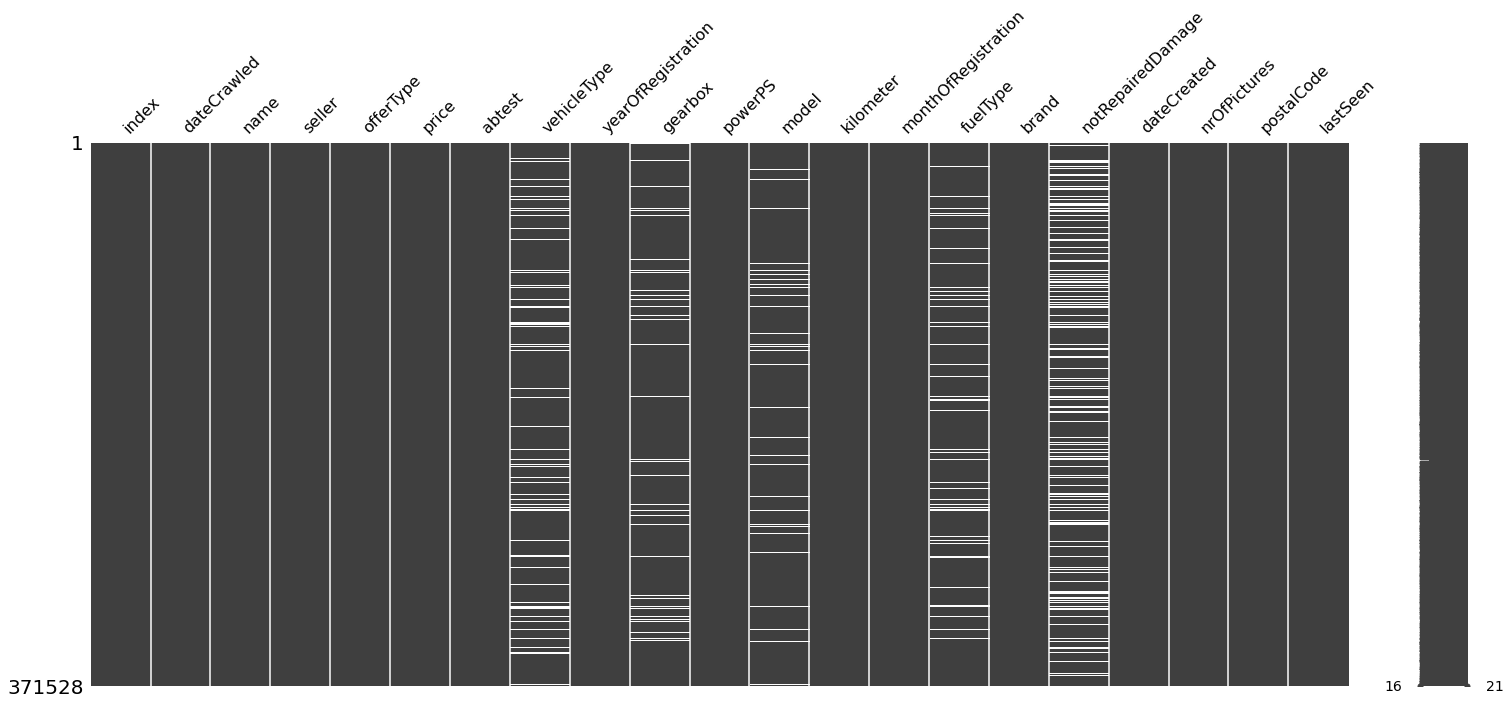

In [4]:
msno.matrix(data)
# data üzerindeki eksik verileri gösterme.

<AxesSubplot:>

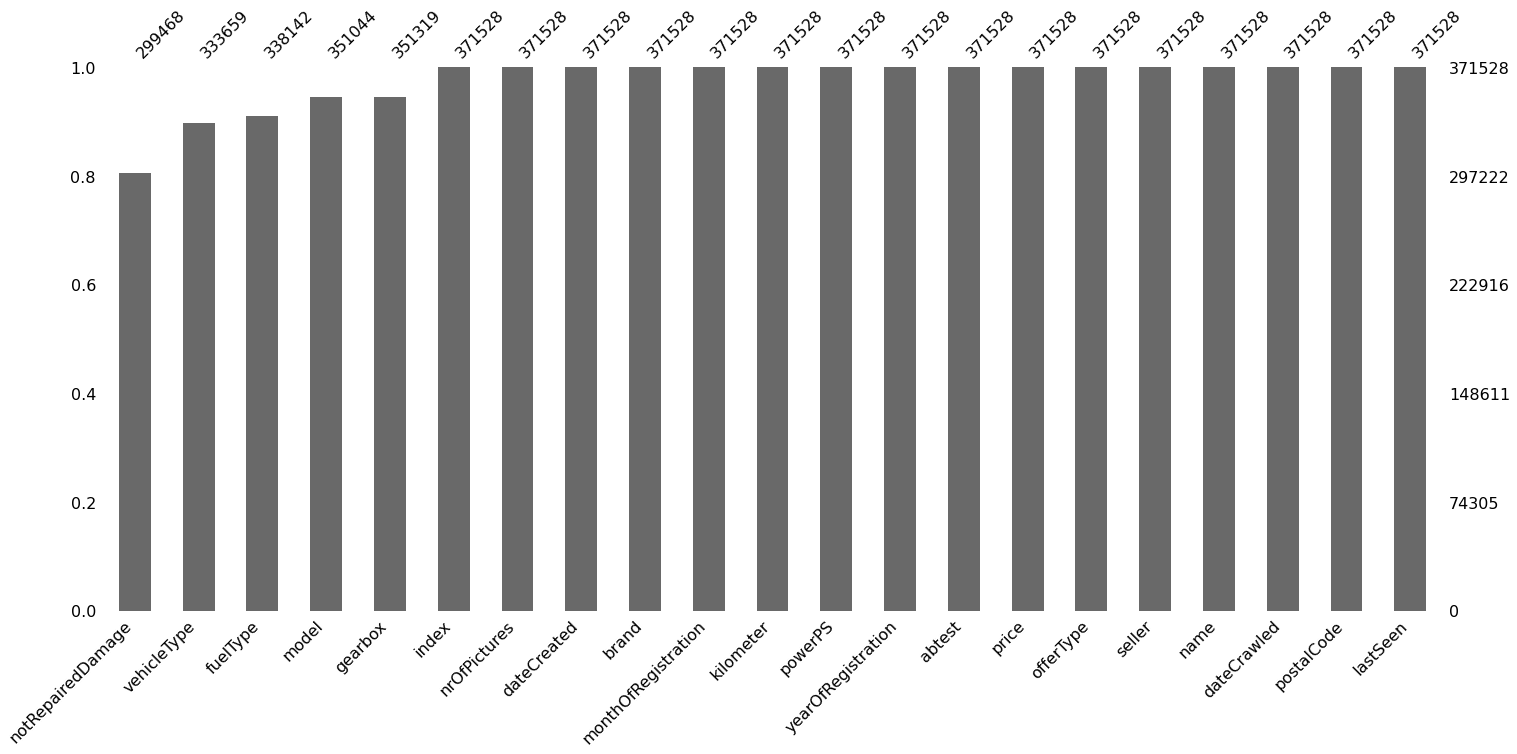

In [5]:
# eksik değerleri kontrol etme
msno.bar(data, sort='ascending')

In [6]:
data.fillna(0, inplace=True)
data = data[data.price > 0]
data = data[data.price < 10**5]
data = data[data.yearOfRegistration > 1900]
data = data[data.yearOfRegistration <= 2023]
data['dateCrawled'] = pd.to_datetime(data['dateCrawled'])
data['yearOfRegistration'] = data['yearOfRegistration'].astype(int)
data['price'] = data['price'].astype(int)
# data üzerindeki eksik verileri yok etme.

<AxesSubplot:>

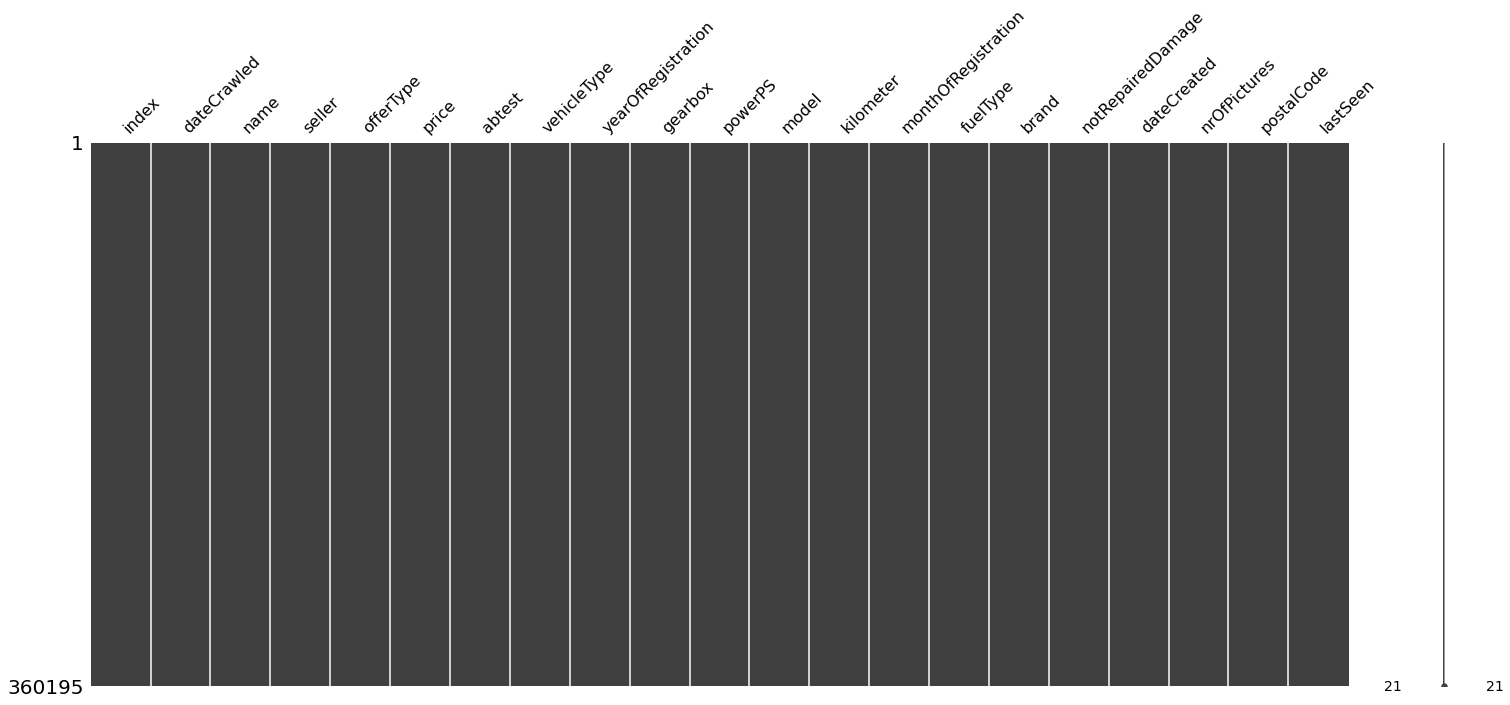

In [7]:
msno.matrix(data)
# data üzerinde temizlik yaptıktan sonra eksik verileri gösterme.

<AxesSubplot:>

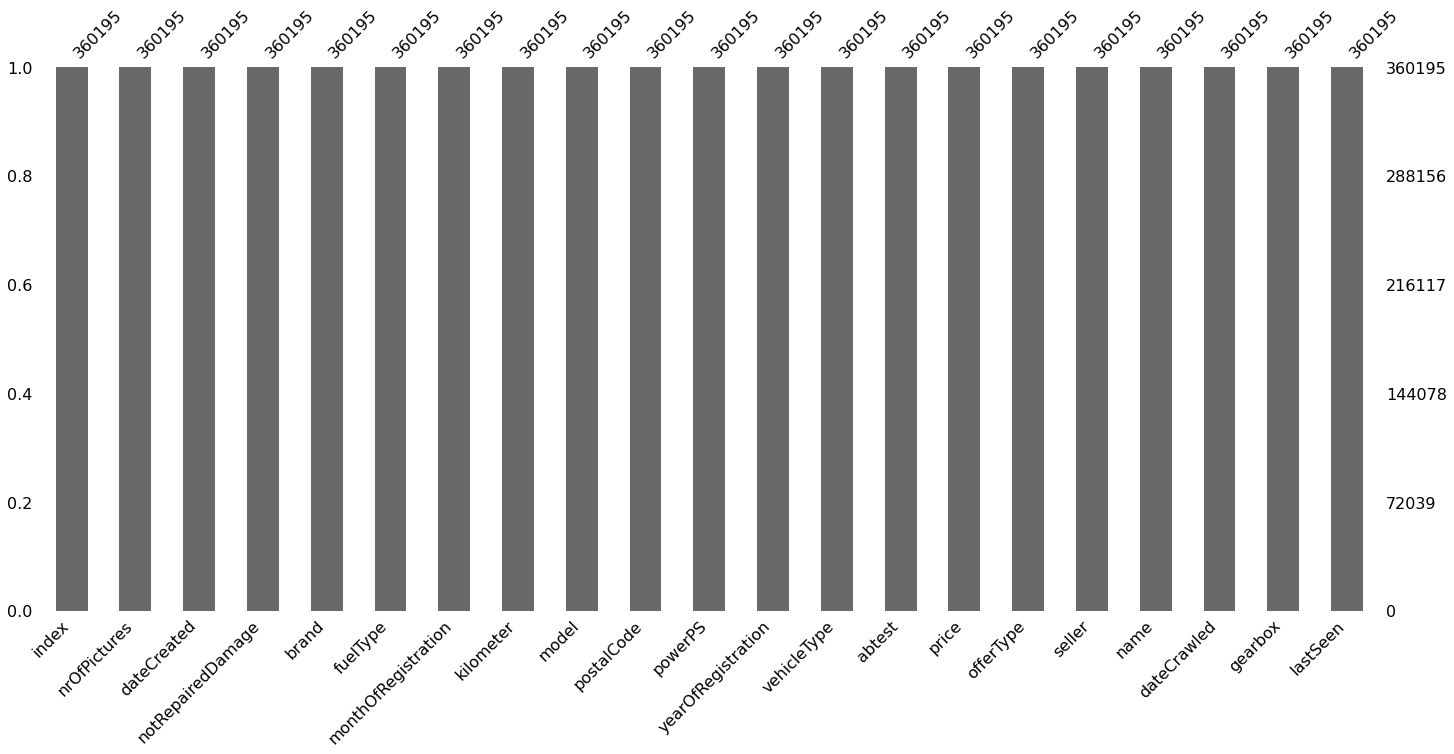

In [8]:
msno.bar(data, sort='ascending')

In [9]:
temp_gearbox_data=data[data['model'].notna()].groupby('model')['gearbox'].agg(lambda x: pd.Series.mode(x)[0]).to_frame()
temp_gearbox_data=temp_gearbox_data.reset_index()
data=data.merge(temp_gearbox_data, on='model', suffixes=('','_tomap'), how='left')
data['gearbox']= np.where((data['gearbox'].isna())&(data['model'].notna()), data['gearbox_tomap'], data['gearbox'])
del temp_gearbox_data
data.drop(['gearbox_tomap'], axis=1, inplace=True)
data['gearbox'].fillna(data['gearbox'].agg(lambda x: pd.Series.mode(x)[0]), inplace=True)
data['gearbox']=pd.factorize(data['gearbox'])[0]

**Data Description**

In [10]:
data.head
print(data.columns), print(type(data)), print("Data shape is :",data.shape)

Index(['index', 'dateCrawled', 'name', 'seller', 'offerType', 'price',
       'abtest', 'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS',
       'model', 'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Data shape is : (360195, 21)


(None, None, None)

In [11]:
# index Sutünunu .iloc komutu ile düşürüyoruz.
data = data.iloc[:,1:]
data.head(), print(data.columns), print("new data shape is :",data.shape)

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')
new data shape is : (360195, 20)


(          dateCrawled                            name  seller offerType  \
 0 2016-03-24 11:52:17                      Golf_3_1.6  privat   Angebot   
 1 2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   Angebot   
 2 2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   Angebot   
 3 2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   Angebot   
 4 2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   Angebot   
 
    price abtest vehicleType  yearOfRegistration  gearbox  powerPS  model  \
 0    480   test           0                1993        0        0   golf   
 1  18300   test       coupe                2011        0      190      0   
 2   9800   test         suv                2004        1      163  grand   
 3   1500   test  kleinwagen                2001        0       75   golf   
 4   3600   test  kleinwagen                2008        0       69  fabia   
 
    kilometer  monthOfRegistration fuelType       brand notRepairedDamage  \
 

<Figure size 2160x720 with 0 Axes>

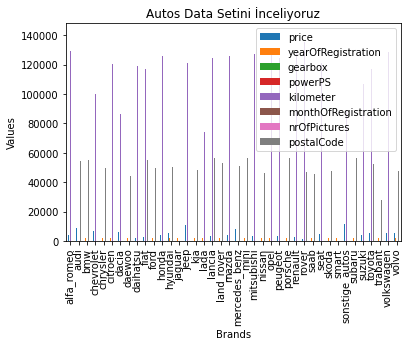

In [12]:
# Her sınıfın ortalamalarını histogram olarak gösteriyoruz.
plt.figure(figsize=(30,10))
data_mean = data.groupby(data.brand).mean()
data_mean.plot.bar()
plt.title("Autos Data Setini İnceliyoruz")
plt.xlabel("Brands")
plt.ylabel("Values")
plt.show()


# Dağılımına bakmak istiyorum: Gaussian Distribution
# data.plot.kde()

In [13]:
data.corr()
# Sayısal değişkenler arasında korelasyon olup olmadığını gösterme.
# Korelasyon katsayısı = -1 < c < 1
# c = -1 (ters yönlü mükemmel ilişki)
# c = 0 (ilişki yok)
# c = 1 (aynı yönlü mükemmel ilişki)
# c = 0.8 (aynı yönlü iyi ilişki)
# c = -0.8 (ters yönlü iyi ilişki)

,price,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
price,1.000000,0.312564,0.170584,0.198329,-0.420572,0.070562,NaN,0.081620
yearOfRegistration,0.312564,1.000000,0.028685,0.054670,-0.228769,0.043301,NaN,0.029995
gearbox,0.170584,0.028685,1.000000,0.039387,-0.049943,-0.064514,NaN,-0.029410
powerPS,0.198329,0.054670,0.039387,1.000000,-0.011595,0.040098,NaN,0.026499
kilometer,-0.420572,-0.228769,-0.049943,-0.011595,1.000000,-0.005754,NaN,-0.028186
monthOfRegistration,0.070562,0.043301,-0.064514,0.040098,-0.005754,1.000000,NaN,0.010673
nrOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalCode,0.081620,0.029995,-0.029410,0.026499,-0.028186,0.010673,NaN,1.000000


<AxesSubplot:>

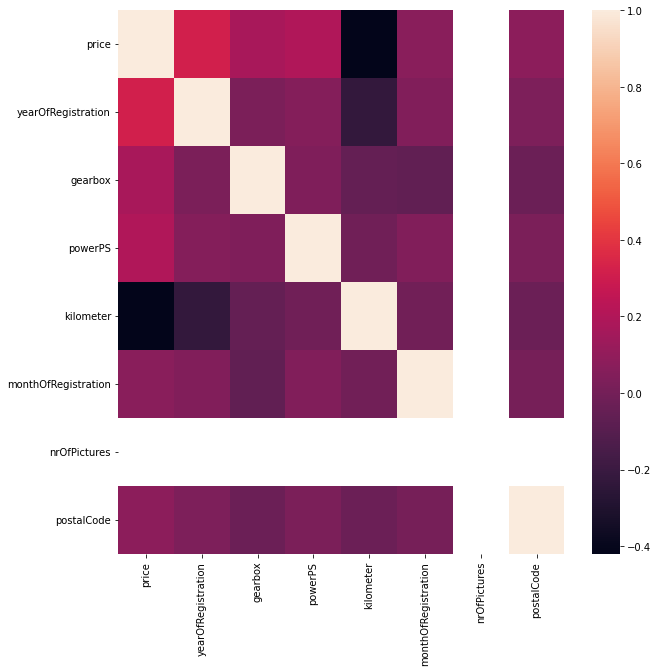

In [14]:
corr = data.corr()
figure, axis=plt.subplots(figsize=(10,10))
sns.heatmap(corr)
# Korelasyon katsayılarını daha iyi okuyabilmek için ısı haritası çizme

In [15]:
# heat map
data.corr().style.background_gradient('Blues')

/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2813: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
/opt/conda/lib/python3.7/site-packages/pandas/io/formats/style.py:2814: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


,price,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
price,1.000000,0.312564,0.170584,0.198329,-0.420572,0.070562,nan,0.081620
yearOfRegistration,0.312564,1.000000,0.028685,0.054670,-0.228769,0.043301,nan,0.029995
gearbox,0.170584,0.028685,1.000000,0.039387,-0.049943,-0.064514,nan,-0.029410
powerPS,0.198329,0.054670,0.039387,1.000000,-0.011595,0.040098,nan,0.026499
kilometer,-0.420572,-0.228769,-0.049943,-0.011595,1.000000,-0.005754,nan,-0.028186
monthOfRegistration,0.070562,0.043301,-0.064514,0.040098,-0.005754,1.000000,nan,0.010673
nrOfPictures,nan,nan,nan,nan,nan,nan,nan,nan
postalCode,0.081620,0.029995,-0.029410,0.026499,-0.028186,0.010673,nan,1.000000


<Figure size 2160x720 with 0 Axes>

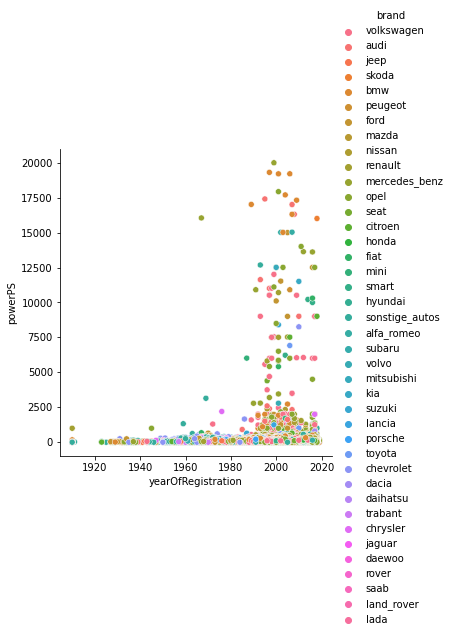

<Figure size 2160x720 with 0 Axes>

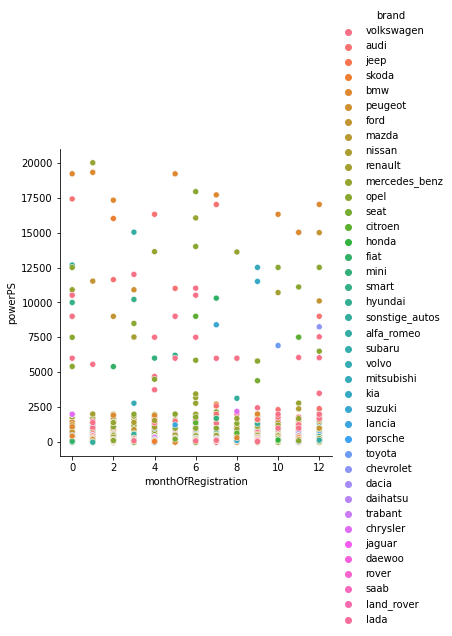

<Figure size 2160x720 with 0 Axes>

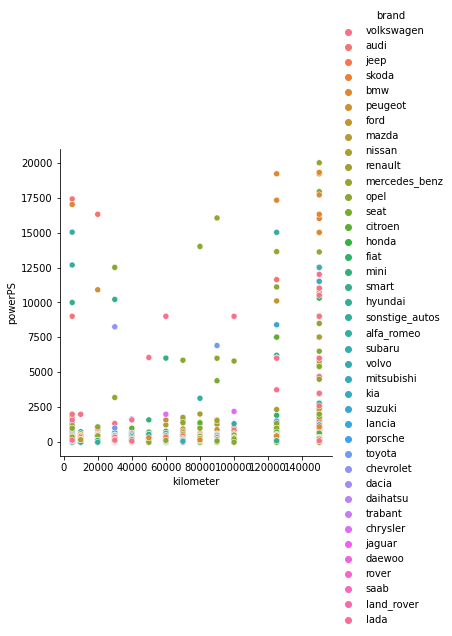

<Figure size 2160x720 with 0 Axes>

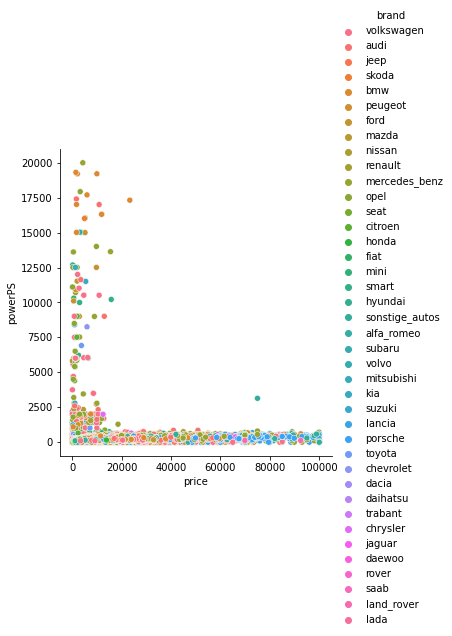

<Figure size 2160x720 with 0 Axes>

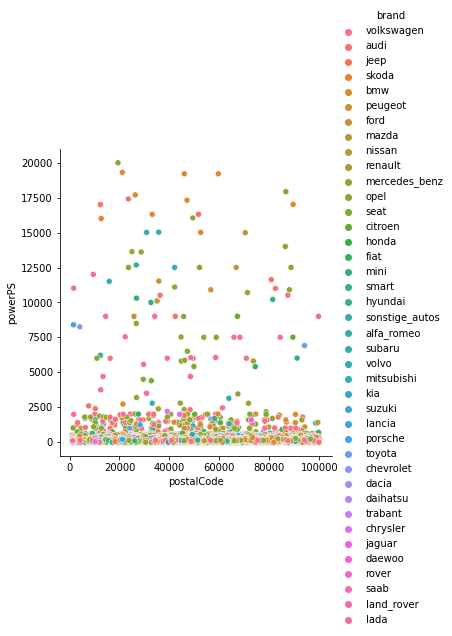

<Figure size 2160x720 with 0 Axes>

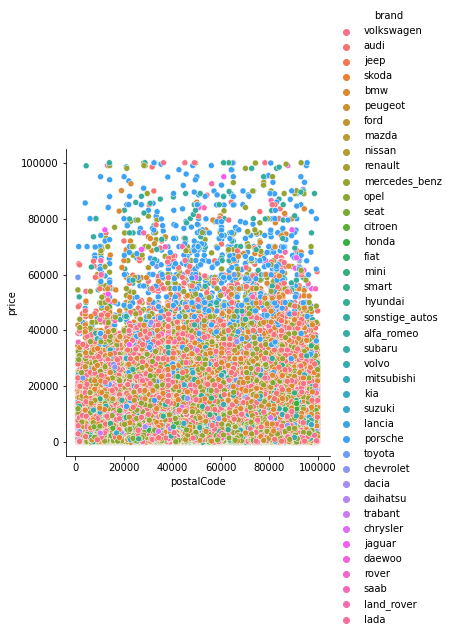

<Figure size 2160x720 with 0 Axes>

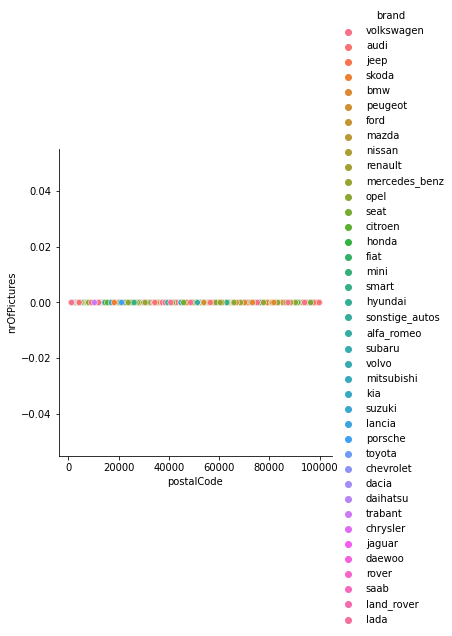

In [16]:
# 2 boyutta dağılımını görme.
plt.figure(figsize=(30,10))
sns.relplot(data=data, x="yearOfRegistration", y="powerPS" ,hue="brand")
plt.show()
plt.figure(figsize=(30,10))
sns.relplot(data=data, x="monthOfRegistration", y="powerPS" ,hue="brand")
plt.show()
plt.figure(figsize=(30,10))
sns.relplot(data=data, x="kilometer", y="powerPS" ,hue="brand")
plt.show()
plt.figure(figsize=(30,10))
sns.relplot(data=data, x="price", y="powerPS" ,hue="brand")
plt.show()
plt.figure(figsize=(30,10))
sns.relplot(data=data, x="postalCode", y="powerPS" ,hue="brand")
plt.show()
plt.figure(figsize=(30,10))
sns.relplot(data=data, x="postalCode", y="price" ,hue="brand")
plt.show()
plt.figure(figsize=(30,10))
sns.relplot(data=data, x="postalCode", y="nrOfPictures" ,hue="brand")
plt.show()

In [17]:
# Sınıflara göre data dağılımını görme.
# sns.pairplot(data,hue ="brand")

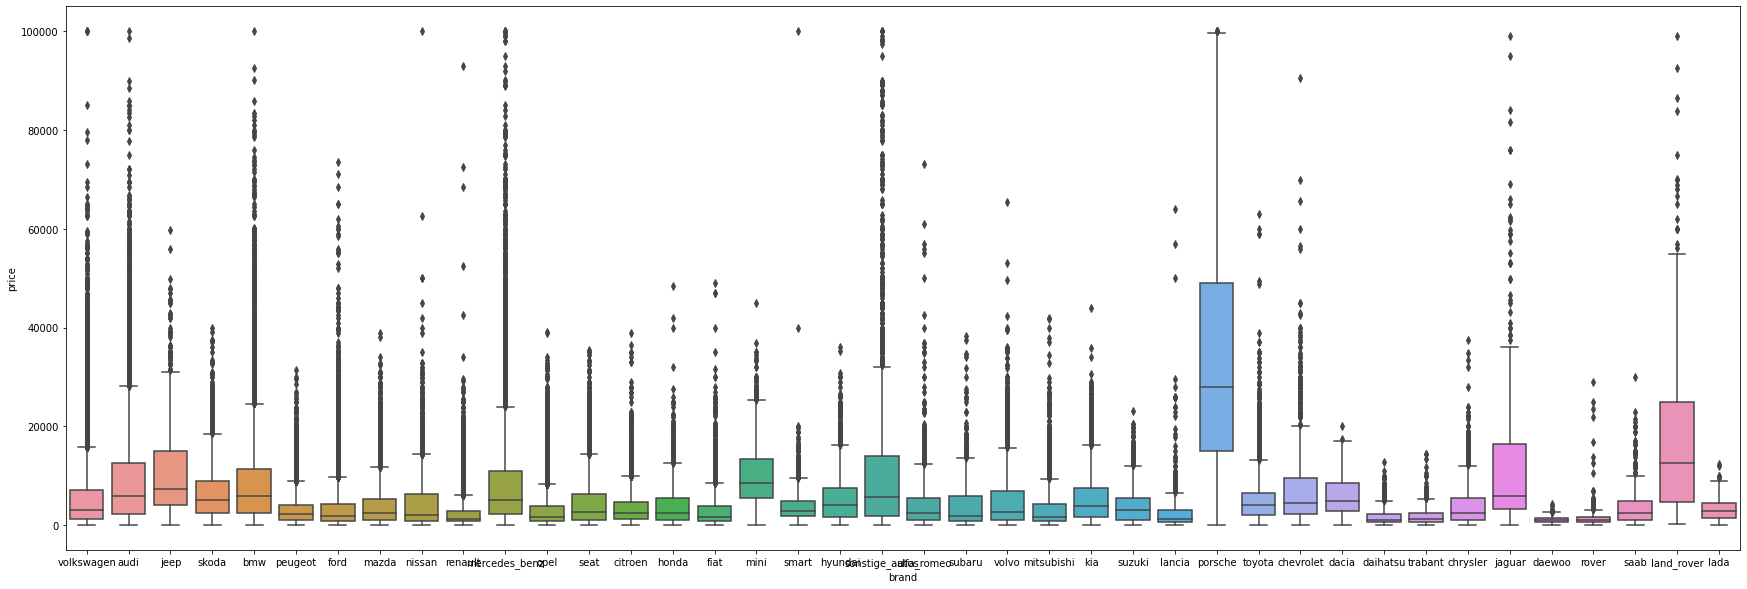

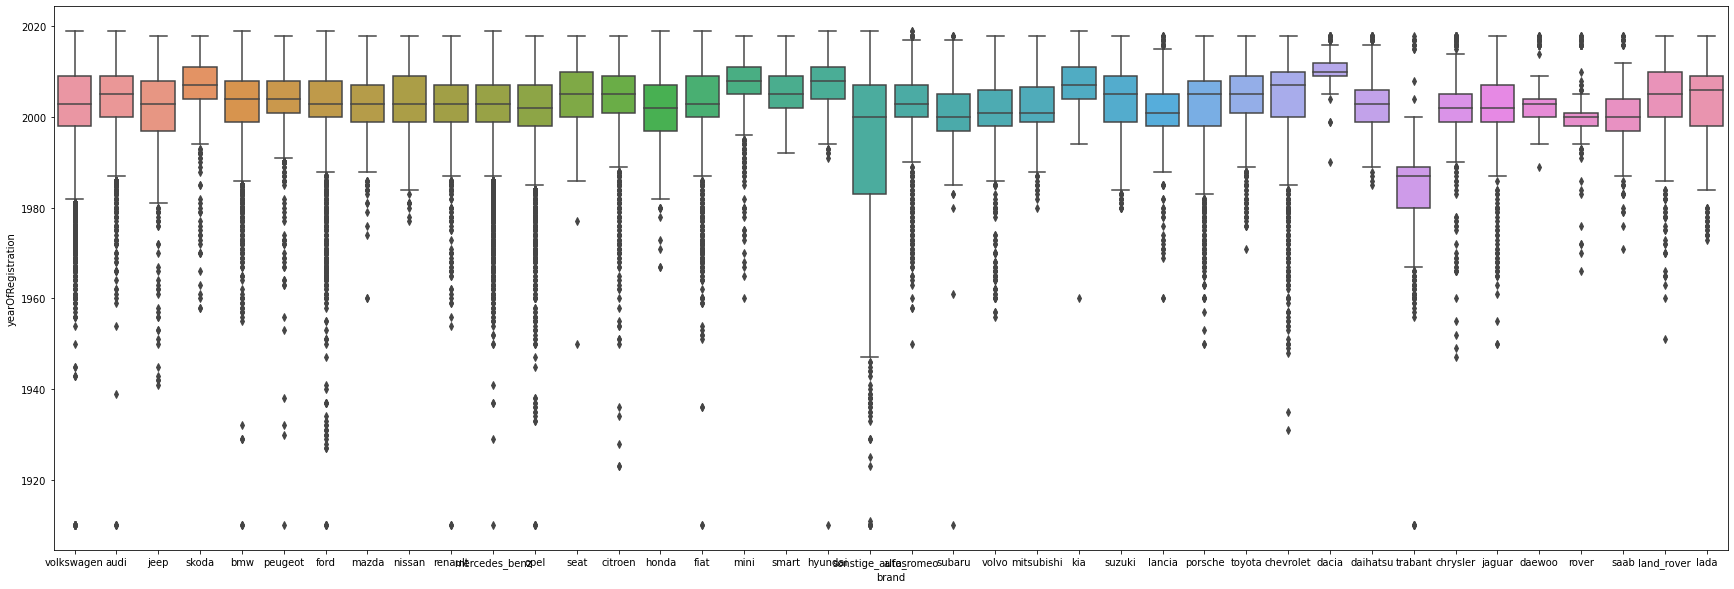

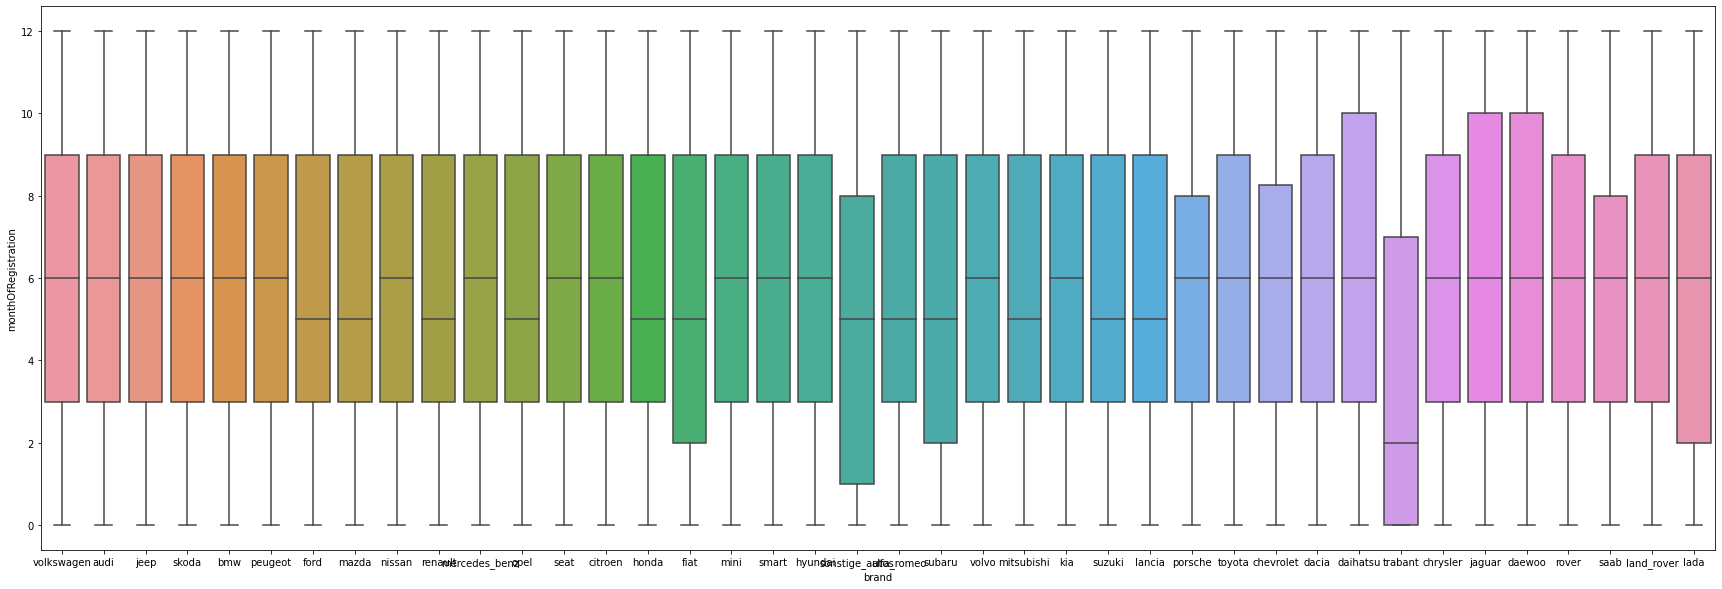

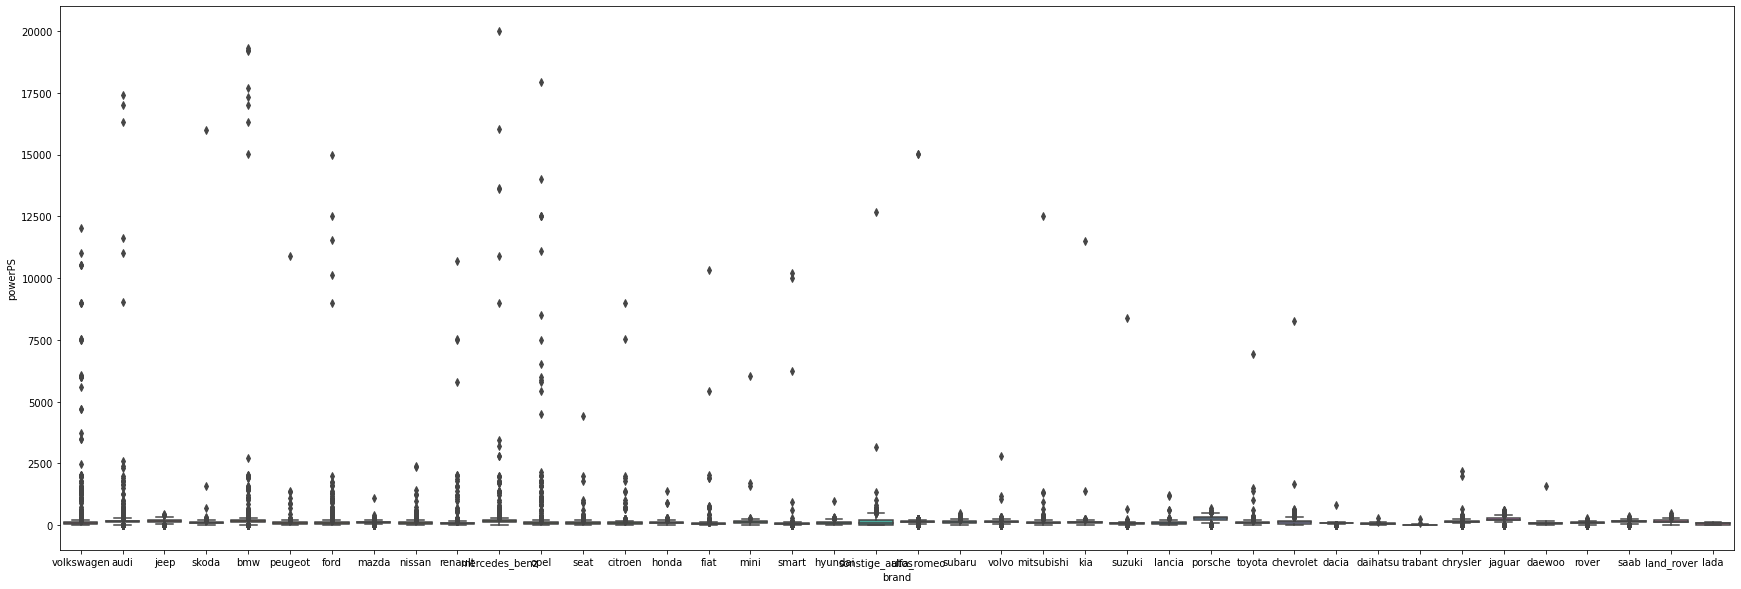

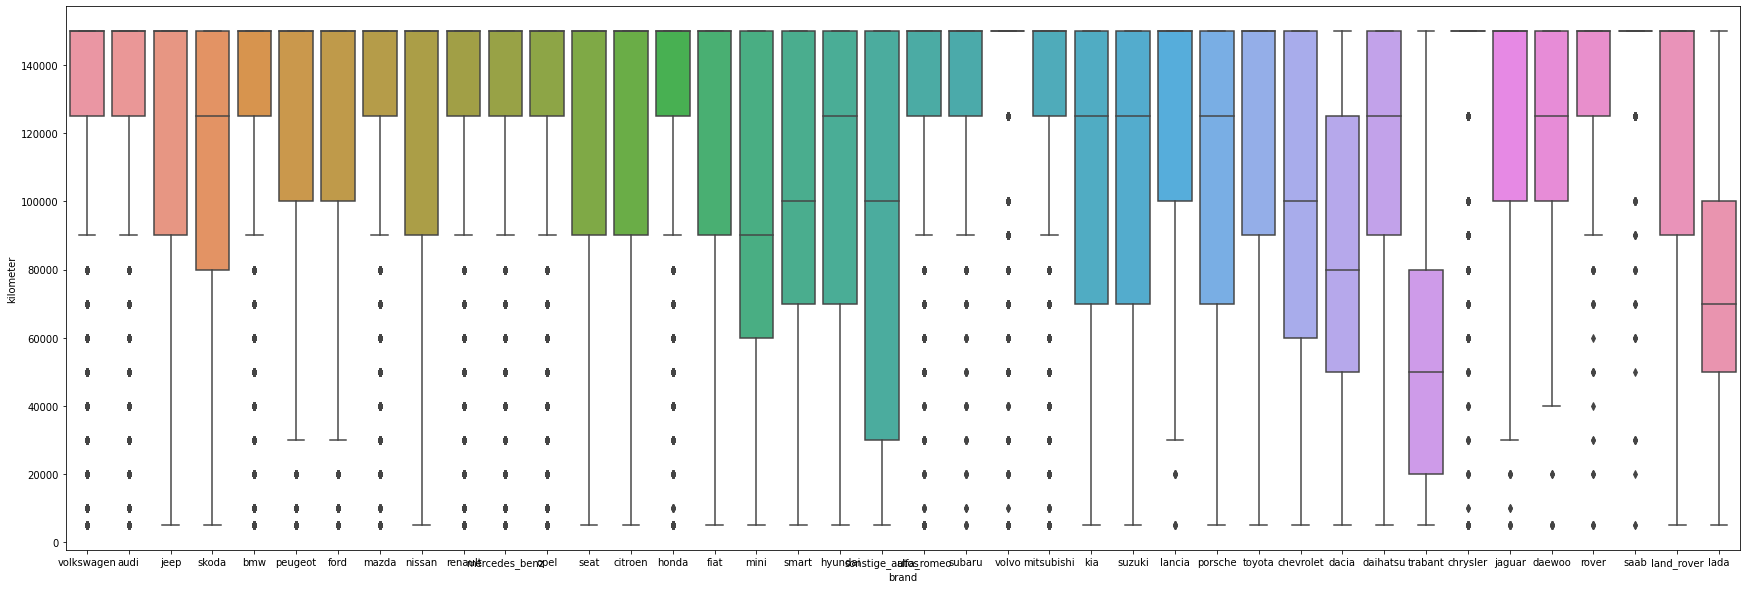

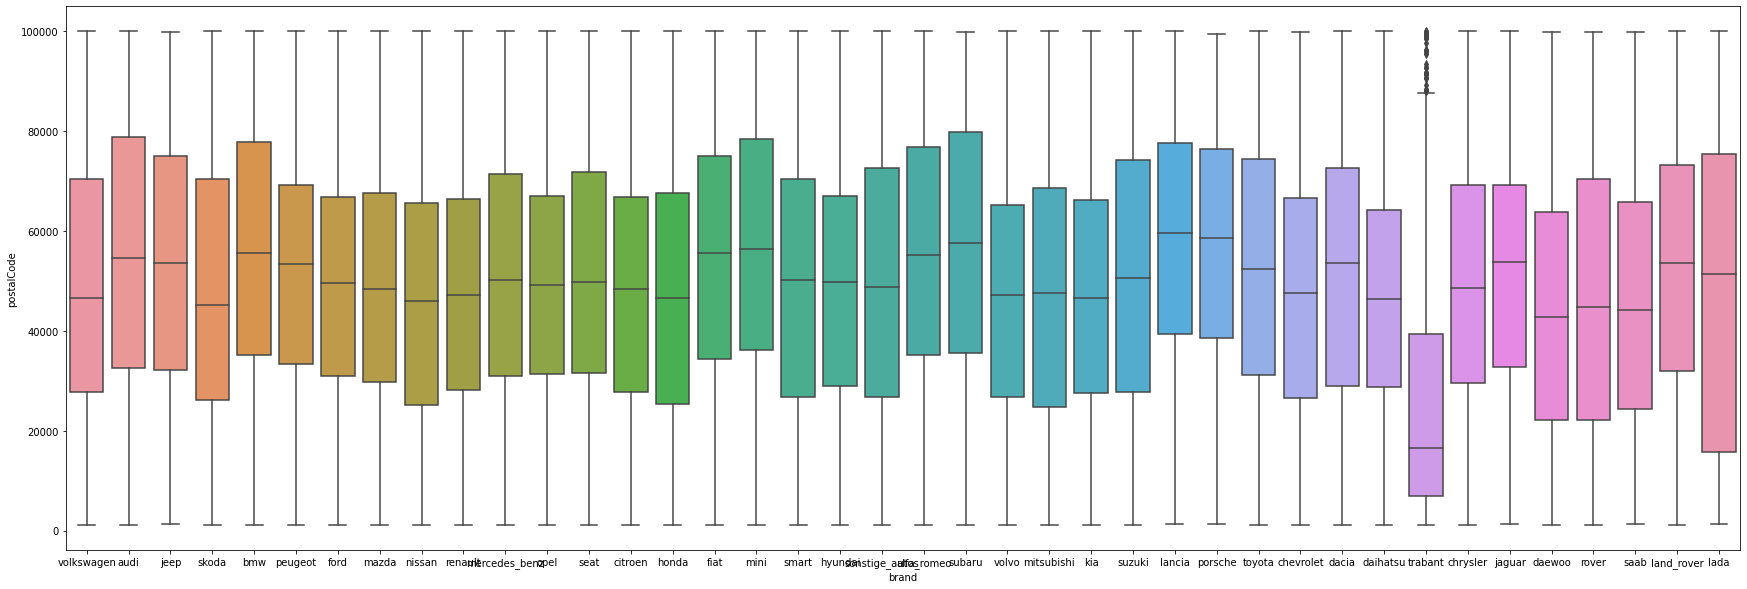

In [18]:
plt.figure(figsize=(30,10))
sns.boxplot(x="brand", y="price",data=data)
plt.show()
plt.figure(figsize=(30,10))
sns.boxplot(x="brand", y="yearOfRegistration",data=data)
plt.show()
plt.figure(figsize=(30,10))
sns.boxplot(x="brand", y="monthOfRegistration",data=data)
plt.show()
plt.figure(figsize=(30,10))
sns.boxplot(x="brand", y="powerPS",data=data)
plt.show()
plt.figure(figsize=(30,10))
sns.boxplot(x="brand", y="kilometer",data=data)
plt.show()
plt.figure(figsize=(30,10))
sns.boxplot(x="brand", y="postalCode",data=data)
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Başarı oranı:  0.21606010002859144
Başarı oranı:  [[   33   268   361 ...     1   312     2]
 [  139  6020  4824 ...     5  4117    27]
 [  157  5128  9566 ...     7  3680    25]
 ...
 [    2    28    23 ...    17    74     0]
 [  171  5084  4706 ...    42 20594    50]
 [    7   467   547 ...     0   382    45]]


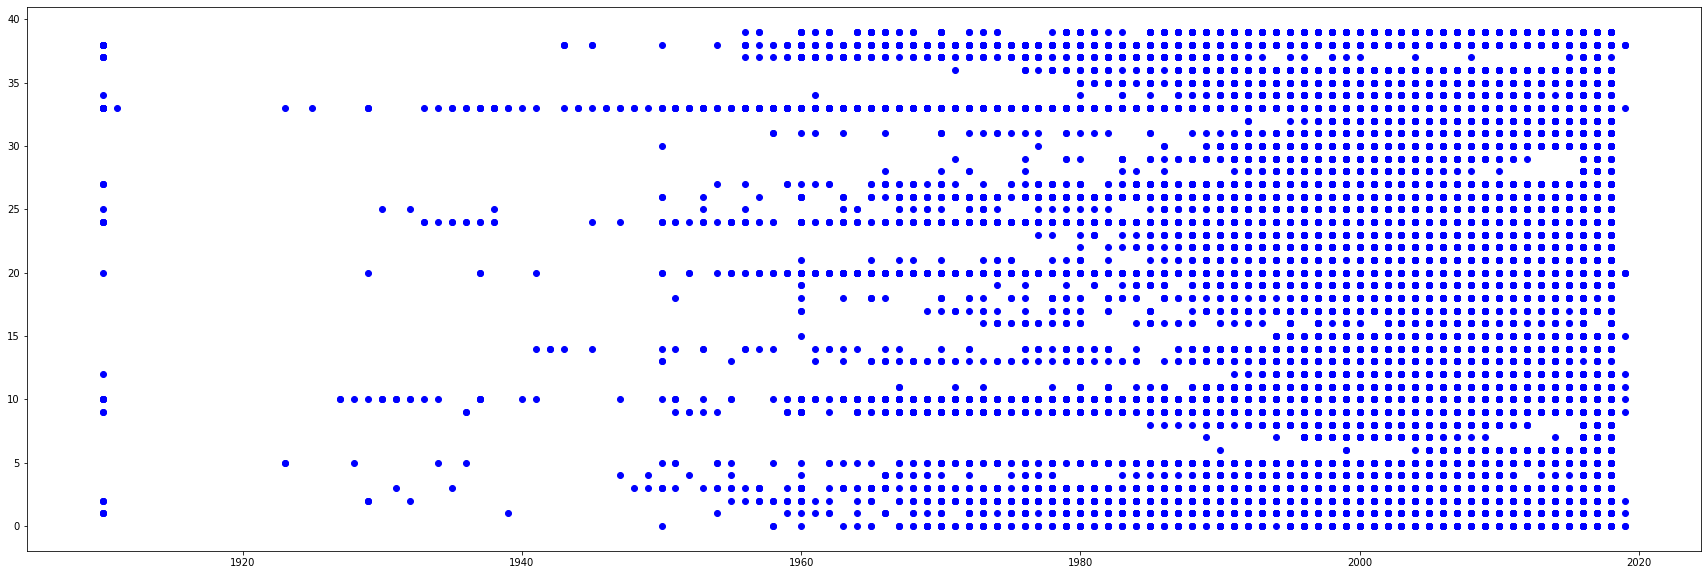

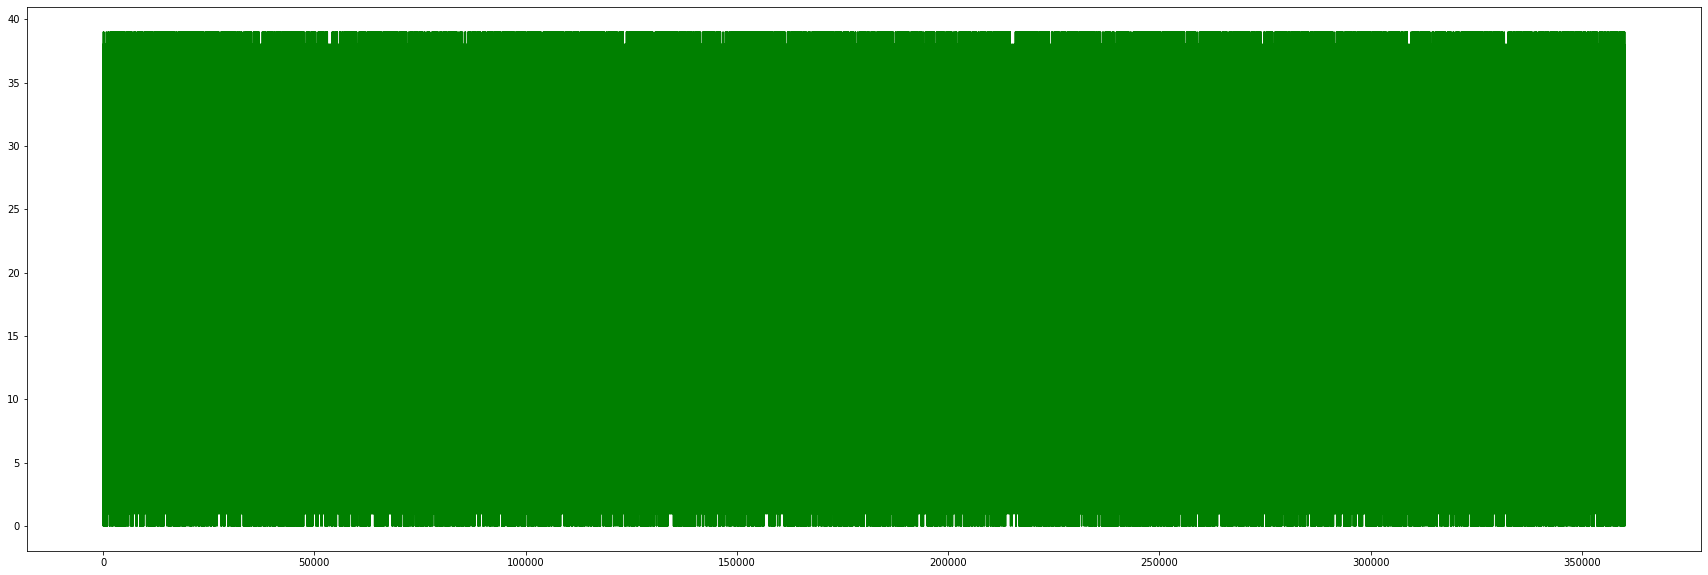

In [19]:
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# x ve y olarak öznitelikler ile çıktı değerlerini ayrı dataframe'lere ayırma
x = data.iloc[:,[7,9,11,12,17,18]]
y = data.iloc[:,14:15]

le = LabelEncoder()
y_trasform = le.fit_transform(y)


x_train, x_test, y_train, y_test = train_test_split(x,y_trasform,train_size=0.33,random_state=0)

knc = KNeighborsClassifier(n_neighbors=8, algorithm = 'auto')
knc.fit(x_train, y_train)
pred = knc.predict(x_test)

ac_sc = accuracy_score(y_test, pred)
print('Başarı oranı: ', ac_sc)

cm = confusion_matrix(y_test, pred)
print('Başarı oranı: ', cm)

plt.figure(figsize=(30,10))
plt.scatter(x.iloc[:,0:1], y_trasform, color = 'blue')
plt.show()
plt.figure(figsize=(30,10))
plt.plot(y_trasform, color ='green')
plt.show()

In [20]:
# x ve y olarak öznitelikler ile çıktı değerlerini ayrı dataframe'lere ayırma
x = data.iloc[:,[7,9,11,12,17,18]]
y = data.iloc[:,14:15]

In [21]:
k_nn=KNeighborsClassifier(n_neighbors=8, metric="chebyshev")
logi = LogisticRegression(random_state=5)
DT = DecisionTreeClassifier(max_features="sqrt")
SDF = SGDClassifier(penalty="l2", random_state=10)
S_VC= SVC(degree=3,C=8,kernel="rbf")
RF= RandomForestClassifier(n_estimators=78, criterion= "gini")
Bayes=  GaussianNB()
MBayes = MultinomialNB()
BBayes = BernoulliNB()
LDA = LinearDiscriminantAnalysis(solver="eigen")
Result = []

In [22]:
# SDF
# cv_sonuc= cross_validate(SDF, x, y, cv=5 , scoring='accuracy')
# res=cv_sonuc['test_score'].mean()

# print("Accuracy of SDF: ", res*100, "%")
# Result.append( "SDF :")
# Result.append(res)

In [23]:
# KNN
cv_sonuc= cross_validate(k_nn, x, y, cv=5 , scoring='accuracy')
res=cv_sonuc['test_score'].mean()

print("Accuracy of KNN: ", res*100, "%")
Result.append( "KNN :")
Result.append(res)

/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for exam

Accuracy of KNN:  24.95537139604936 %


In [24]:
# LOGISTIC REGRESSION
cv_sonuc= cross_validate(logi, x, y, cv=5 , scoring='accuracy')
res=cv_sonuc['test_score'].mean()

print("Accuracy of Logistic Regression: ", res*100, "%")
Result.append( "LR :")
Result.append(res)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

Accuracy of Logistic Regression:  21.357597967767454 %


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [25]:
# Decision Tree
cv_sonuc= cross_validate(DT, x, y, cv=5 , scoring='accuracy')
res=cv_sonuc['test_score'].mean()

print("Accuracy of Decision Tree: ", res*100, "%")
Result.append( "DT :")
Result.append(res)

Accuracy of Decision Tree:  42.97949721678535 %


In [26]:
# Support Vector Classifier
# cv_sonuc= cross_validate(S_VC, x, y, cv=5 , scoring='accuracy')
# res=cv_sonuc['test_score'].mean()

# print("Accuracy of Support Vector Classifier: ", res*100, "%")
# Result.append( "SVC :")
# Result.append(res)

In [27]:
# Linear Discriminant Analysis
cv_sonuc= cross_validate(LDA, x, y, cv=5 , scoring='accuracy')
res=cv_sonuc['test_score'].mean()
print("Accuracy of Linear Discriminant Analysis: ", res*100, "%")
Result.append( "LDA :")
Result.append(res)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Accuracy of Linear Discriminant Analysis:  nan %


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 603, in fit
    covariance_estimator=self.covariance_estimator,
  File "/opt/conda/lib/python3.7/site-packages/sklearn/discriminant_analysis.py", line 440, in _solve_eigen
    evals, evecs = linalg.eigh(Sb, Sw)
  File "/opt/conda/lib/

In [28]:
data_dummy = pd.get_dummies(data, prefix='vehicleType', prefix_sep='.', columns=['vehicleType'])
data_dummy = pd.get_dummies(data_dummy, prefix='fuelType', prefix_sep='.', columns=['fuelType'], drop_first=True)

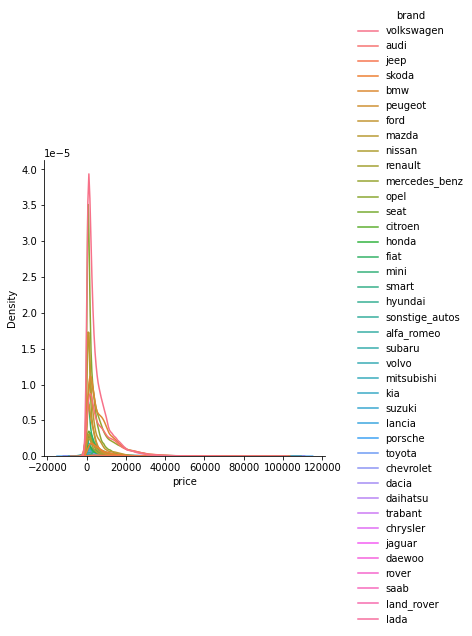

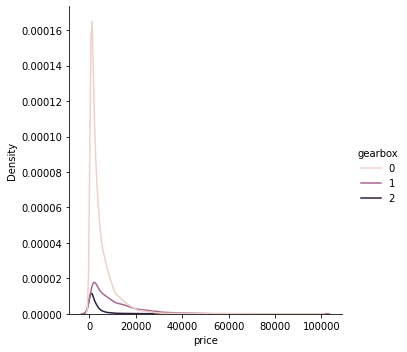

In [29]:
sns.displot(data = data_dummy, x='price', kind='kde', hue='brand')
sns.displot(data = data_dummy, x='price', kind='kde', hue='gearbox')

In [30]:
temp = abs(data.corr()['price']).sort_values(ascending=False) 
temp

price                  1.000000
kilometer              0.420572
yearOfRegistration     0.312564
powerPS                0.198329
gearbox                0.170584
postalCode             0.081620
monthOfRegistration    0.070562
nrOfPictures                NaN
Name: price, dtype: float64

In [31]:
data

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,0,1993,0,0,golf,150000,0,benzin,volkswagen,0,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,0,190,0,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,1,163,grand,125000,8,diesel,jeep,0,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,0,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,0,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360190,2016-03-14 17:48:27,Suche_t4___vito_ab_6_sitze,privat,Angebot,2200,test,0,2005,2,0,0,20000,1,0,sonstige_autos,0,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
360191,2016-03-05 19:56:21,Smart_smart_leistungssteigerung_100ps,privat,Angebot,1199,test,cabrio,2000,1,101,fortwo,125000,3,benzin,smart,nein,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
360192,2016-03-19 18:57:12,Volkswagen_Multivan_T4_TDI_7DC_UY2,privat,Angebot,9200,test,bus,1996,0,102,transporter,150000,3,diesel,volkswagen,nein,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
360193,2016-03-20 19:41:08,VW_Golf_Kombi_1_9l_TDI,privat,Angebot,3400,test,kombi,2002,0,100,golf,150000,6,diesel,volkswagen,0,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [32]:
data.isna().sum()
# Veri çercevesinde hangi öznitelikte kaç tane eksik değer olduğunu bulma.

dateCrawled            0
name                   0
seller                 0
offerType              0
price                  0
abtest                 0
vehicleType            0
yearOfRegistration     0
gearbox                0
powerPS                0
model                  0
kilometer              0
monthOfRegistration    0
fuelType               0
brand                  0
notRepairedDamage      0
dateCreated            0
nrOfPictures           0
postalCode             0
lastSeen               0
dtype: int64

In [33]:
data.info()
# Veri çercevesindeki değişkenlerin hangi tipte olduğuna bakma.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360195 entries, 0 to 360194
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          360195 non-null  datetime64[ns]
 1   name                 360195 non-null  object        
 2   seller               360195 non-null  object        
 3   offerType            360195 non-null  object        
 4   price                360195 non-null  int64         
 5   abtest               360195 non-null  object        
 6   vehicleType          360195 non-null  object        
 7   yearOfRegistration   360195 non-null  int64         
 8   gearbox              360195 non-null  int64         
 9   powerPS              360195 non-null  int64         
 10  model                360195 non-null  object        
 11  kilometer            360195 non-null  int64         
 12  monthOfRegistration  360195 non-null  int64         
 13  fuelType      

In [34]:
data.describe()
# Veri çercevesindeki sayısal değişkenler için temel istatistik değerlerini görüntüleme.

,price,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
count,360195.000000,360195.000000,360195.000000,360195.000000,360195.000000,360195.000000,360195.0,360195.000000
mean,5774.426491,2003.450889,0.307148,116.281101,125784.394564,5.798473,0.0,50994.424984
std,7540.670995,7.607041,0.556976,188.484717,39689.414264,3.683933,0.0,25760.562966
min,1.000000,1910.000000,0.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1250.000000,1999.000000,0.000000,72.000000,125000.000000,3.000000,0.0,30823.000000
50%,3000.000000,2004.000000,0.000000,105.000000,150000.000000,6.000000,0.0,49744.000000
75%,7450.000000,2008.000000,1.000000,150.000000,150000.000000,9.000000,0.0,71672.000000
max,99999.000000,2019.000000,2.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [35]:
data.describe().T
# Veri çercevesindeki sayısal değişkenler için temel istatistik değerlerini görüntüleme.

,count,mean,std,min,25%,50%,75%,max
price,360195.0,5774.426491,7540.670995,1.0,1250.0,3000.0,7450.0,99999.0
yearOfRegistration,360195.0,2003.450889,7.607041,1910.0,1999.0,2004.0,2008.0,2019.0
gearbox,360195.0,0.307148,0.556976,0.0,0.0,0.0,1.0,2.0
powerPS,360195.0,116.281101,188.484717,0.0,72.0,105.0,150.0,20000.0
kilometer,360195.0,125784.394564,39689.414264,5000.0,125000.0,150000.0,150000.0,150000.0
monthOfRegistration,360195.0,5.798473,3.683933,0.0,3.0,6.0,9.0,12.0
nrOfPictures,360195.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
postalCode,360195.0,50994.424984,25760.562966,1067.0,30823.0,49744.0,71672.0,99998.0


In [36]:
data.head(10)
# Veri çercevesinin ilk 10 verisi.

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,0,1993,0,0,golf,150000,0,benzin,volkswagen,0,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,0,190,0,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,1,163,grand,125000,8,diesel,jeep,0,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,0,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,0,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,privat,Angebot,650,test,limousine,1995,0,102,3er,150000,10,benzin,bmw,ja,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,Peugeot_206_CC_110_Platinum,privat,Angebot,2200,test,cabrio,2004,0,109,2_reihe,150000,8,benzin,peugeot,nein,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-04-04 23:42:13,Ford_C___Max_Titanium_1_0_L_EcoBoost,privat,Angebot,14500,control,bus,2014,0,125,c_max,30000,8,benzin,ford,0,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
8,2016-03-17 10:53:50,VW_Golf_4_5_tuerig_zu_verkaufen_mit_Anhaengerk...,privat,Angebot,999,test,kleinwagen,1998,0,101,golf,150000,0,0,volkswagen,0,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
9,2016-03-26 19:54:18,Mazda_3_1.6_Sport,privat,Angebot,2000,control,limousine,2004,0,105,3_reihe,150000,12,benzin,mazda,nein,2016-03-26 00:00:00,0,96224,2016-04-06 10:45:34


In [37]:
data.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')

In [38]:
data.shape
 # Veri çercevesinin kaç özniteliğe ve kaç gözleme sahip olduğuna bakma.

(360195, 20)

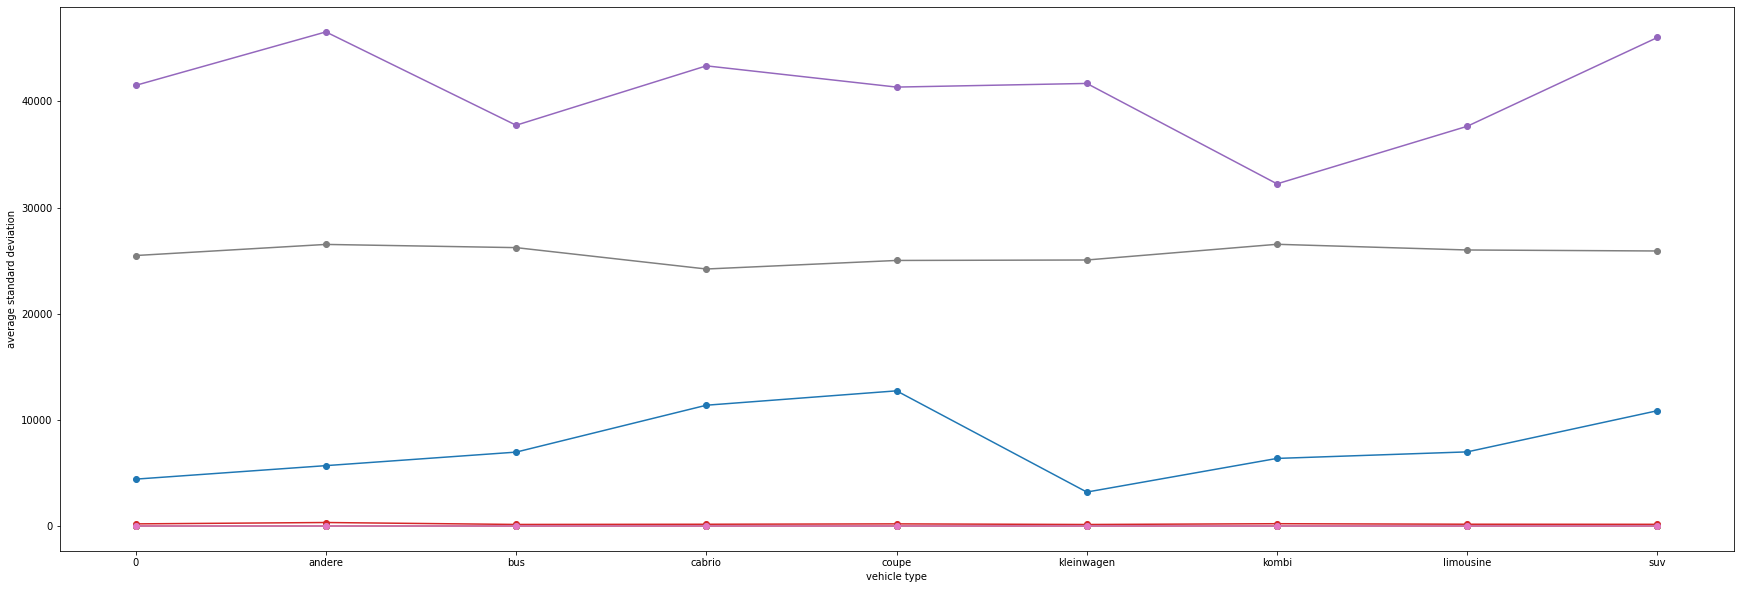

In [39]:
plt.figure(figsize=(30,10))
stdData = data.groupby(["vehicleType"]).std()
features = ["0", "andere", "bus", "cabrio", "coupe", "kleinwagen", "kombi", "limousine", "suv"]
plt.plot(features, stdData, marker="o")
plt.xlabel('vehicle type')
plt.ylabel('average standard deviation')
plt.show()

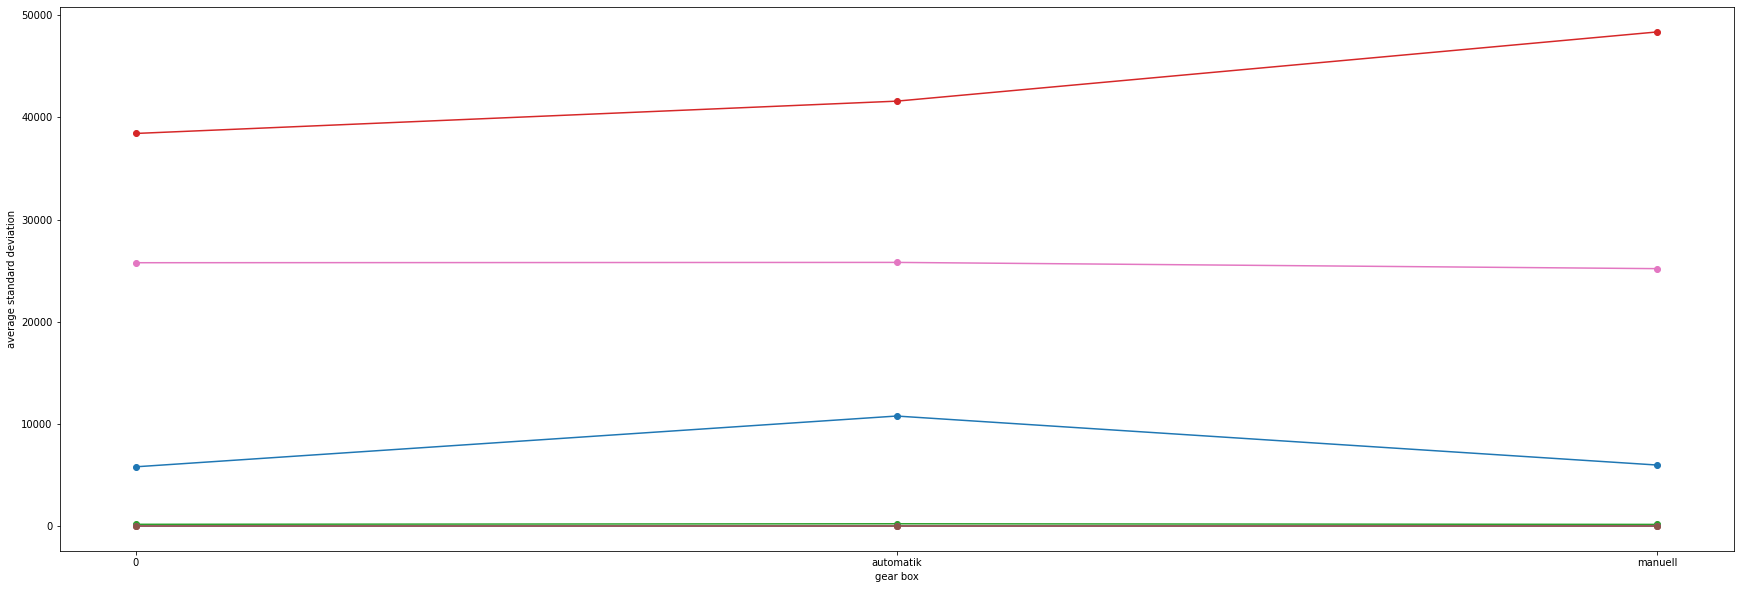

In [40]:
plt.figure(figsize=(30,10))
stdData = data.groupby(["gearbox"]).std()
features = ["0", "automatik", "manuell"]
plt.plot(features, stdData, marker="o")
plt.xlabel('gear box')
plt.ylabel('average standard deviation')
plt.show()

In [41]:
data.groupby(["vehicleType"]).mean()

,price,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
vehicleType,,,,,,,,
0,2901.007779,2010.971270,0.588473,73.445973,128854.347762,4.047706,0.0,48332.495359
andere,4325.358844,1999.018419,0.240076,99.420451,122210.225468,5.378850,0.0,46030.087647
bus,6710.576622,2004.252528,0.216410,114.005678,129018.916104,6.180257,0.0,50470.579847
cabrio,10090.040960,2001.688838,0.311607,145.172121,112603.846668,5.551890,0.0,54128.281599
coupe,10361.532922,2000.593738,0.371674,171.964756,122562.155073,5.915797,0.0,54095.181629
kleinwagen,2793.037966,2002.417688,0.155034,68.995524,119024.577377,5.819173,0.0,50158.660686
kombi,5819.505652,2003.700068,0.313732,136.831127,135800.484225,6.107074,0.0,50590.317621
limousine,5946.019529,2001.971677,0.310297,132.454184,128143.854600,6.054493,0.0,51680.524177
suv,13188.548354,2005.510803,0.531373,166.609443,112751.777456,6.263409,0.0,52521.740181


In [42]:
data.groupby(["brand"]).mean()

,price,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
brand,,,,,,,,
alfa_romeo,4252.098585,2002.680813,0.158709,144.452697,129398.762157,5.556587,0.0,55213.438992
audi,8924.955898,2004.327828,0.401770,157.437303,129725.688906,6.057677,0.0,54471.769166
bmw,8301.880725,2003.394551,0.401758,166.521877,132980.729912,5.970839,0.0,55372.374003
chevrolet,7095.740513,2002.705357,0.440290,131.892299,100178.571429,5.785156,0.0,48304.202567
chrysler,4119.955797,2001.897101,0.598551,149.393478,134380.434783,5.894928,0.0,49549.407246
citroen,3694.181854,2004.597351,0.217632,90.112670,120487.250445,5.760032,0.0,48483.895434
dacia,5905.268539,2010.491011,0.043820,82.580899,86292.134831,6.338202,0.0,51660.832584
daewoo,1034.998124,2003.001876,0.183865,71.030019,123808.630394,6.232645,0.0,44332.180113
daihatsu,1761.402581,2003.090323,0.227097,56.042581,119277.419355,6.005161,0.0,47489.796129


In [43]:
data.groupby(["model"]).mean()

,price,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
model,,,,,,,,
0,4557.847673,2001.341110,0.530113,98.683267,122473.803221,4.449647,0.0,48542.021509
100,1870.482323,1990.813131,0.234848,127.027778,143068.181818,4.906566,0.0,52945.570707
145,879.413043,1999.413043,0.304348,89.500000,132391.304348,5.043478,0.0,50614.478261
147,2302.874113,2004.976950,0.122340,139.358156,135718.085106,5.746454,0.0,55770.054965
156,1581.784053,2002.083056,0.144518,138.068106,144717.607973,5.468439,0.0,54380.117940
...,...,...,...,...,...,...,...,...
yaris,3893.096117,2005.874757,0.145631,74.019417,111199.029126,6.184466,0.0,54660.201942
yeti,14654.351759,2012.030151,0.226131,122.859296,66934.673367,6.155779,0.0,55211.864322
ypsilon,1451.945274,2002.671642,0.159204,67.885572,124527.363184,5.606965,0.0,58433.139303


In [44]:
data.groupby(["gearbox"]).mean()

,price,yearOfRegistration,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
gearbox,,,,,,,
0,4633.302270,2003.211624,105.639154,126978.502916,5.835234,0.0,51421.540130
1,10427.836839,2004.563360,171.820120,122604.341783,6.169674,0.0,49986.082772
2,3110.224578,2002.303352,39.151163,121297.594619,3.640390,0.0,48833.583333


In [45]:
data.groupby(["fuelType"]).mean()

,price,yearOfRegistration,gearbox,powerPS,kilometer,monthOfRegistration,nrOfPictures,postalCode
fuelType,,,,,,,,
0,3074.203910,2004.158902,0.606019,83.941591,127677.425856,3.932859,0.0,48503.973063
andere,3875.575581,1993.994186,0.581395,64.296512,88750.000000,4.325581,0.0,43838.250000
benzin,4806.503455,2002.054872,0.229280,111.247157,122467.810174,5.800322,0.0,51012.235497
cng,4766.688730,2006.400716,0.116279,100.123435,127880.143113,6.354204,0.0,49004.463327
diesel,8570.080496,2006.161538,0.376002,134.212627,131488.927821,6.305971,0.0,51883.680211
elektro,10941.479167,2008.270833,0.989583,73.166667,46666.666667,6.000000,0.0,55192.312500
hybrid,12977.866171,2009.836431,0.869888,117.026022,84907.063197,6.605948,0.0,50169.275093
lpg,4432.803937,2002.144659,0.422511,150.304988,141944.391363,5.983566,0.0,46794.063826


In [46]:
data.groupby(["powerPS"]).mean()

,price,yearOfRegistration,gearbox,kilometer,monthOfRegistration,nrOfPictures,postalCode
powerPS,,,,,,,
0,2845.130522,2002.106299,0.743550,127438.898404,4.227823,0.0,46846.604953
1,1840.888889,1998.666667,0.407407,84444.444444,5.296296,0.0,48713.000000
2,4323.333333,2004.777778,0.555556,87222.222222,5.444444,0.0,37153.222222
3,2731.000000,1998.875000,0.500000,34375.000000,8.000000,0.0,77438.000000
4,3041.500000,2001.200000,0.733333,45166.666667,6.533333,0.0,51440.533333
...,...,...,...,...,...,...,...
17932,3250.000000,2001.000000,1.000000,150000.000000,6.000000,0.0,86641.000000
19208,2100.000000,2001.000000,0.000000,150000.000000,5.000000,0.0,59556.000000
19211,9999.000000,2006.000000,0.000000,125000.000000,0.000000,0.0,45964.000000


In [47]:
data.groupby(["brand"])["price"].std()

brand
alfa_romeo         5499.598092
audi               9293.577387
bmw                8434.461479
chevrolet          7663.732554
chrysler           4563.499954
citroen            3836.366309
dacia              3661.334727
daewoo              636.596650
daihatsu           1880.663428
fiat               3318.615750
ford               5015.900090
honda              4221.036849
hyundai            5042.067460
jaguar            14218.744732
jeep              10191.104077
kia                5781.049197
lada               2259.132327
lancia             6277.265284
land_rover        15042.698860
mazda              4571.325273
mercedes_benz      9188.800910
mini               5706.581640
mitsubishi         4483.517162
nissan             5836.998445
opel               3537.188168
peugeot            3286.409267
porsche           23046.109431
renault            3123.840490
rover              2694.457096
saab               4182.288900
seat               4811.898253
skoda              5363.522138
sm

In [48]:
data.groupby(["vehicleType"])["price"].std()

vehicleType
0              4421.750510
andere         5693.435614
bus            6967.166088
cabrio        11383.545794
coupe         12737.845143
kleinwagen     3204.301606
kombi          6373.345851
limousine      6989.072524
suv           10868.383339
Name: price, dtype: float64

In [49]:
data.groupby(["model"])["price"].std()

model
0          8434.476013
100        1951.071868
145         944.340654
147        1600.048141
156        1323.605656
              ...     
yaris      2740.445488
yeti       4156.321956
ypsilon    1508.580131
z_reihe    9125.907682
zafira     2823.113412
Name: price, Length: 252, dtype: float64

In [50]:
print(data["powerPS"].max())
print(data["price"].max())
print(data["yearOfRegistration"].max())
print(data["kilometer"].max())
print(data["monthOfRegistration"].max())

20000
99999
2019
150000
12


In [51]:
print(data["powerPS"].min())
print(data["price"].min())
print(data["yearOfRegistration"].min())
print(data["kilometer"].min())
print(data["monthOfRegistration"].min())

0
1
1910
5000
0


In [52]:
print("Result 1: ")
data[(data["powerPS"] > 10000) & (data["brand"] == "bmw")]


Result 1: 


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
53792,2016-03-22 20:48:06,BMW_E70_X5_3.0D_Panoramadach,privat,Angebot,23333,control,suv,2009,1,17322,x_reihe,125000,2,diesel,bmw,nein,2016-03-22 00:00:00,0,47051,2016-04-06 14:45:40
116018,2016-04-03 07:36:21,BMW_120D_Diesel_M_packet_Vollauslastung,privat,Angebot,9999,test,limousine,2006,0,19211,1er,125000,0,diesel,bmw,0,2016-04-03 00:00:00,0,45964,2016-04-07 10:16:10
134655,2016-03-25 14:55:49,BMW_E39_5er_525i,privat,Angebot,2100,control,kombi,2001,0,19208,5er,150000,5,0,bmw,ja,2016-03-25 00:00:00,0,59556,2016-03-30 05:16:18
190415,2016-03-17 19:50:23,BMW_E30_touring_325i_Projektaufgabe_325e_viele...,privat,Angebot,1749,control,kombi,1989,0,17019,3er,5000,12,benzin,bmw,0,2016-03-17 00:00:00,0,89542,2016-03-26 00:46:59
199773,2016-03-20 16:51:48,Verkaufe_meinen_bmw_525d,privat,Angebot,6000,test,kombi,2004,1,17700,5er,150000,7,diesel,bmw,nein,2016-03-20 00:00:00,0,26316,2016-04-06 22:45:56
265182,2016-03-11 13:59:35,Bmw_320d,privat,Angebot,1750,test,kombi,2003,1,15017,3er,150000,11,diesel,bmw,0,2016-03-11 00:00:00,0,52525,2016-03-11 14:41:51
304116,2016-03-09 08:53:11,Verkaufe_BMW_528i,privat,Angebot,1500,test,kombi,1997,0,19312,5er,150000,1,0,bmw,nein,2016-03-09 00:00:00,0,21129,2016-04-07 11:44:34
316560,2016-04-02 15:50:55,BMW_520_Touring__mit__Austauschmoter_38tsd_km_...,privat,Angebot,11900,control,kombi,2007,1,16311,5er,150000,10,diesel,bmw,nein,2016-04-02 00:00:00,0,33100,2016-04-06 14:45:57


In [53]:
print("Result 2: ")
data[(data["kilometer"] > 140000) & (data["vehicleType"] == "bus")]

Result 2: 


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
17,2016-03-23 15:48:05,Ford_C_MAX_2.0_TDCi_DPF_Titanium,privat,Angebot,7550,test,bus,2007,0,136,c_max,150000,6,diesel,ford,nein,2016-03-23 00:00:00,0,88361,2016-04-05 18:45:11
18,2016-04-01 22:55:47,Mercedes_Benz_A_160_Classic_Klima,privat,Angebot,1850,test,bus,2004,0,102,a_klasse,150000,1,benzin,mercedes_benz,nein,2016-04-01 00:00:00,0,49565,2016-04-05 22:46:05
38,2016-03-25 15:50:30,Mercedes_Camper_D407,privat,Angebot,1500,test,bus,1984,0,70,andere,150000,8,diesel,mercedes_benz,nein,2016-03-25 00:00:00,0,22767,2016-03-27 03:17:02
47,2016-04-04 14:06:22,Mercedes_Benz_B180_Automatik,privat,Angebot,13500,test,bus,2012,1,109,b_klasse,150000,7,diesel,mercedes_benz,nein,2016-04-04 00:00:00,0,35576,2016-04-05 12:09:29
77,2016-03-10 10:50:26,Mercedes_Benz_311_CDI_Sprinter_DOKA_6_SITZ._TÜ...,privat,Angebot,5000,test,bus,2006,0,109,sprinter,150000,4,diesel,mercedes_benz,nein,2016-03-10 00:00:00,0,26382,2016-03-12 14:45:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360121,2016-03-26 01:00:19,Mercedes_Benz_211_CDI_Sprinter,privat,Angebot,2550,test,bus,2003,0,109,sprinter,150000,6,diesel,mercedes_benz,ja,2016-03-25 00:00:00,0,28205,2016-04-05 17:50:01
360133,2016-03-10 11:51:32,Vito_108_CDI,privat,Angebot,1650,test,bus,2002,0,66,vito,150000,2,diesel,mercedes_benz,nein,2016-03-10 00:00:00,0,27576,2016-03-10 12:42:33
360169,2016-03-26 18:36:54,Chrysler_Voyager,privat,Angebot,3900,test,bus,2003,1,174,voyager,150000,7,benzin,chrysler,nein,2016-03-26 00:00:00,0,34320,2016-04-06 09:16:04
360189,2016-03-27 20:36:20,Opel_Zafira_1.6_Elegance_TÜV_12/16,privat,Angebot,1150,control,bus,2000,0,0,zafira,150000,3,benzin,opel,nein,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23


In [54]:
print("Result 3: ")
data[(data["powerPS"] > 19000) & (data["gearbox"] == "automatik") & (data["brand"] == "mercedes_benz")]

Result 3: 


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen


In [55]:
print("Result 4: ")
data[(data["powerPS"] > 2000) & (data["yearOfRegistration"] > 2015) & (data["price"] > 7000) &  (data["brand"] == "bmw")]

Result 4: 


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
352408,2016-03-24 11:50:41,Bmw_530d_tuev_euro_4_top_gepflegt_!,privat,Angebot,7498,test,0,2017,1,2018,5er,150000,9,0,bmw,nein,2016-03-24 00:00:00,0,59425,2016-03-30 12:46:26


In [56]:
print("Result 5: ")
data[(data["kilometer"] < 7000) & (data["yearOfRegistration"] > 2018) & (data["price"] > 6000)]

Result 5: 


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
181555,2016-03-12 22:40:12,"VW_POLO_1_2_TSI_BlueMotionTechnology_""Sondermo...",privat,Angebot,15500,control,0,2019,0,90,polo,5000,0,benzin,volkswagen,nein,2016-03-12 00:00:00,0,58640,2016-03-12 22:40:12


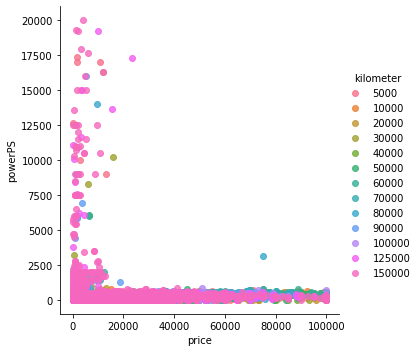

In [57]:
sns.lmplot(x = 'price', y = 'powerPS', fit_reg = False, hue = 'kilometer', data = data)

AxesSubplot(0.125,0.125;0.775x0.755)


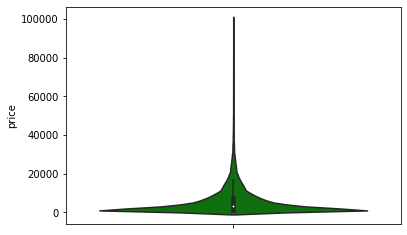

In [58]:
print(sns.violinplot(y = "price", data=data, color="green"))
# Normal dağılımda mod, medyan ve aritmetik ortalama birbirine eşittir.
# Eğrinin maksimum noktası aritmetik ortalamadır (dolayısıyla mod ve medyandır).
# Eğri aritmetik ortalamaya göre simetriktir.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


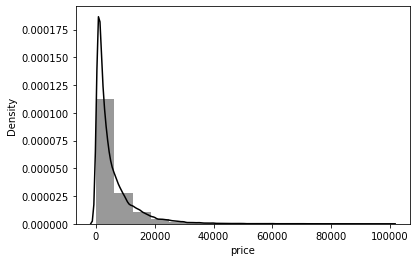

In [59]:
sns.distplot(data["price"], bins=16, color="black");
# distplot çizdirme

AxesSubplot(0.125,0.125;0.775x0.755)


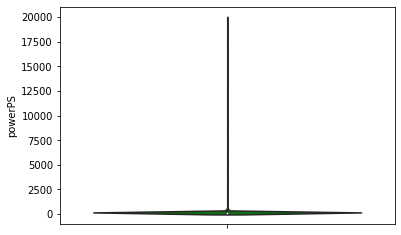

In [60]:
print(sns.violinplot(y = "powerPS", data=data, color="green"))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


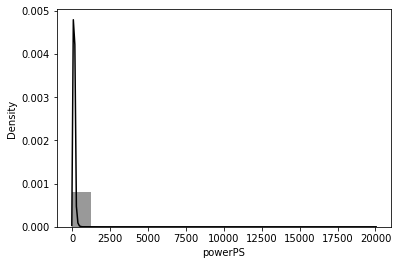

In [61]:
sns.distplot(data["powerPS"], bins=16, color="black");
# distplot çizdirme

AxesSubplot(0.125,0.125;0.775x0.755)


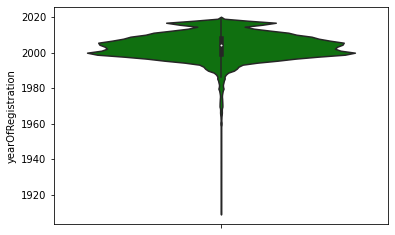

In [62]:
print(sns.violinplot(y = "yearOfRegistration", data=data, color="green"))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


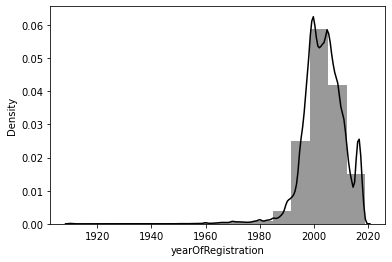

In [63]:
sns.distplot(data["yearOfRegistration"], bins=16, color="black");
# distplot çizdirme

AxesSubplot(0.125,0.125;0.775x0.755)


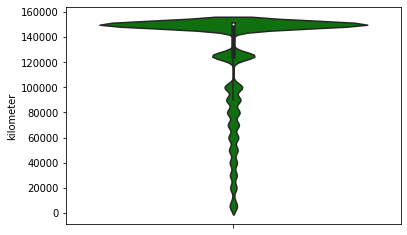

In [64]:
print(sns.violinplot(y = "kilometer", data=data, color="green"))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


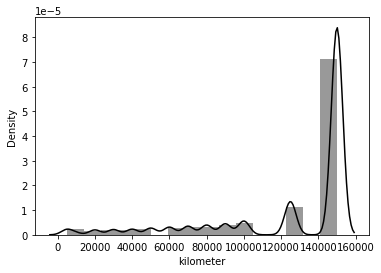

In [65]:
sns.distplot(data["kilometer"], bins=16, color="black");
# distplot çizdirme

AxesSubplot(0.125,0.125;0.775x0.755)


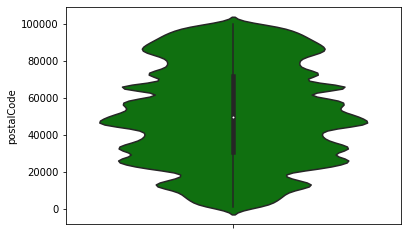

In [66]:
print(sns.violinplot(y = "postalCode", data=data, color="green"))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


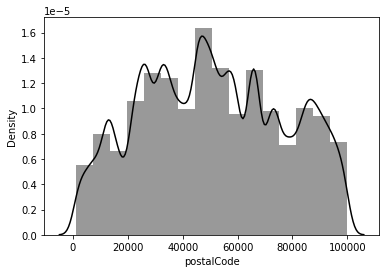

In [67]:
sns.distplot(data["postalCode"], bins=16, color="black");
# distplot çizdirme

**value_counts()**

In [68]:
name_count = data['name'].value_counts()
print(name_count)

print("\nNumber of Unique Values:")
print(data["name"].nunique())

print("\nUnique Values:")
data.name.unique()

Ford_Fiesta                                     644
BMW_318i                                        627
Opel_Corsa                                      609
Volkswagen_Golf_1.4                             603
BMW_316i                                        523
                                               ... 
Mazda_626__TÜV_09.2017                            1
Mercedes_Benz_C320                                1
Golf_3_Cabrio_1_8l_ca.1_5_Jahre_Tuev!             1
citroen_jumpy_vandalismusschaden_                 1
BMW_M135i_vollausgestattet_NP_52.720____Euro      1
Name: name, Length: 224572, dtype: int64

Number of Unique Values:
224572

Unique Values:


array(['Golf_3_1.6', 'A5_Sportback_2.7_Tdi',
       'Jeep_Grand_Cherokee_"Overland"', ...,
       'Smart_smart_leistungssteigerung_100ps', 'VW_Golf_Kombi_1_9l_TDI',
       'BMW_M135i_vollausgestattet_NP_52.720____Euro'], dtype=object)

In [69]:
price_count = data['price'].value_counts()
print(price_count)

print("\nNumber of Unique Values:")
print(data["price"].nunique())

print("\nUnique Values:")
data.price.unique()

500      5662
1500     5390
1000     4647
1200     4593
2500     4435
         ... 
56590       1
24488       1
6001        1
272         1
10985       1
Name: price, Length: 5382, dtype: int64

Number of Unique Values:
5382

Unique Values:


array([  480, 18300,  9800, ..., 18429, 24895, 10985])

In [70]:
vehicleType_count = data['vehicleType'].value_counts()
print(vehicleType_count)

print("\nNumber of Unique Values:")
print(data["vehicleType"].nunique())

print("\nUnique Values:")
data.vehicleType.unique()

limousine     93810
kleinwagen    78202
kombi         66085
0             33937
bus           29763
cabrio        22461
coupe         18301
suv           14487
andere         3149
Name: vehicleType, dtype: int64

Number of Unique Values:
9

Unique Values:


array([0, 'coupe', 'suv', 'kleinwagen', 'limousine', 'cabrio', 'bus',
       'kombi', 'andere'], dtype=object)

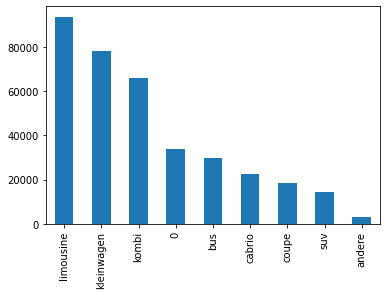

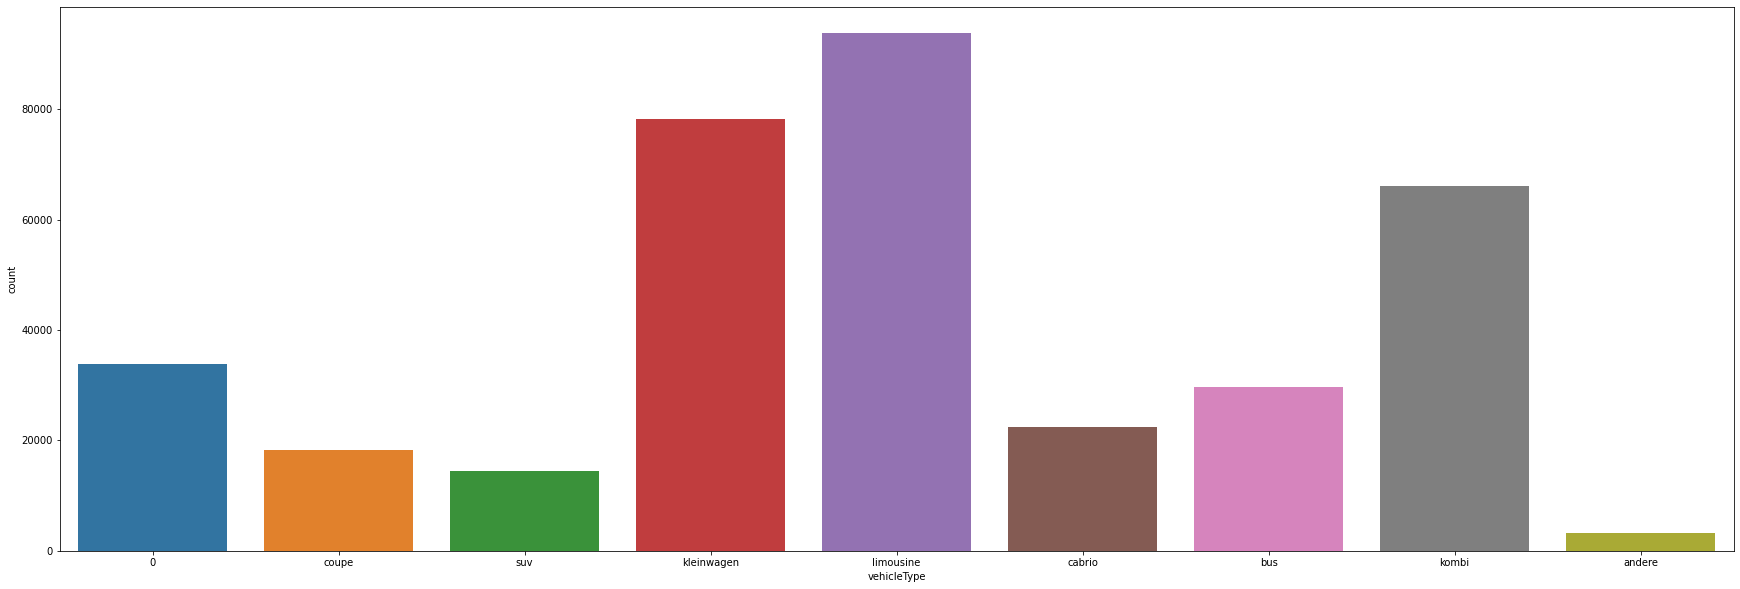

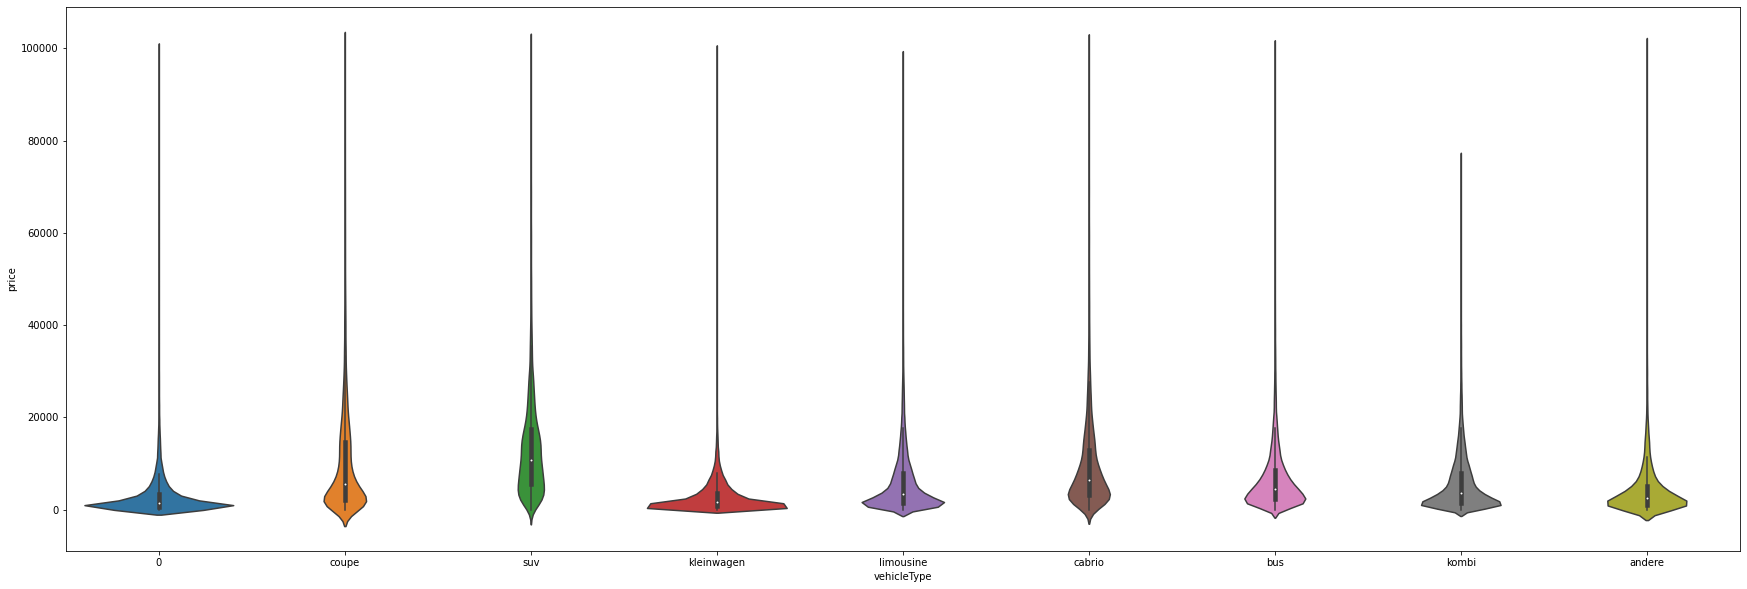

In [71]:
vehicleType_graph = px.bar(x=vehicleType_count.index, y=vehicleType_count.values, labels={'x':'Vehicle Type', 'y':'Number of Cars'})
vehicleType_graph.show()

vehicleType_count.plot.bar()
plt.show()

plt.figure(figsize=(30,10))
sns.countplot(x='vehicleType', data=data)
plt.show()

plt.figure(figsize=(30,10))
sns.violinplot(x = "vehicleType", y = "price", data=data);
plt.show()

In [72]:
brand_count = data['brand'].value_counts()
print(brand_count)

print("\nNumber of Unique Values:")
print(data["brand"].nunique())

print("\nUnique Values:")
data.brand.unique()

volkswagen        76978
bmw               39128
opel              38711
mercedes_benz     34564
audi              31971
ford              24839
renault           17425
peugeot           10808
fiat               9359
seat               6830
skoda              5574
mazda              5540
smart              5173
citroen            5059
nissan             4903
toyota             4623
hyundai            3591
mini               3357
sonstige_autos     3336
volvo              3238
mitsubishi         2962
honda              2734
kia                2497
suzuki             2276
alfa_romeo         2262
porsche            2031
chevrolet          1792
chrysler           1380
dacia               890
jeep                786
daihatsu            775
land_rover          755
subaru              750
jaguar              601
daewoo              533
saab                519
trabant             496
lancia              470
rover               466
lada                213
Name: brand, dtype: int64

Number of Uni

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'porsche', 'toyota', 'chevrolet',
       'dacia', 'daihatsu', 'trabant', 'chrysler', 'jaguar', 'daewoo',
       'rover', 'saab', 'land_rover', 'lada'], dtype=object)

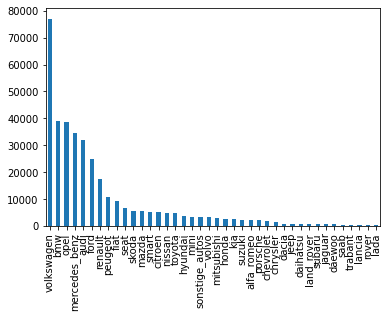

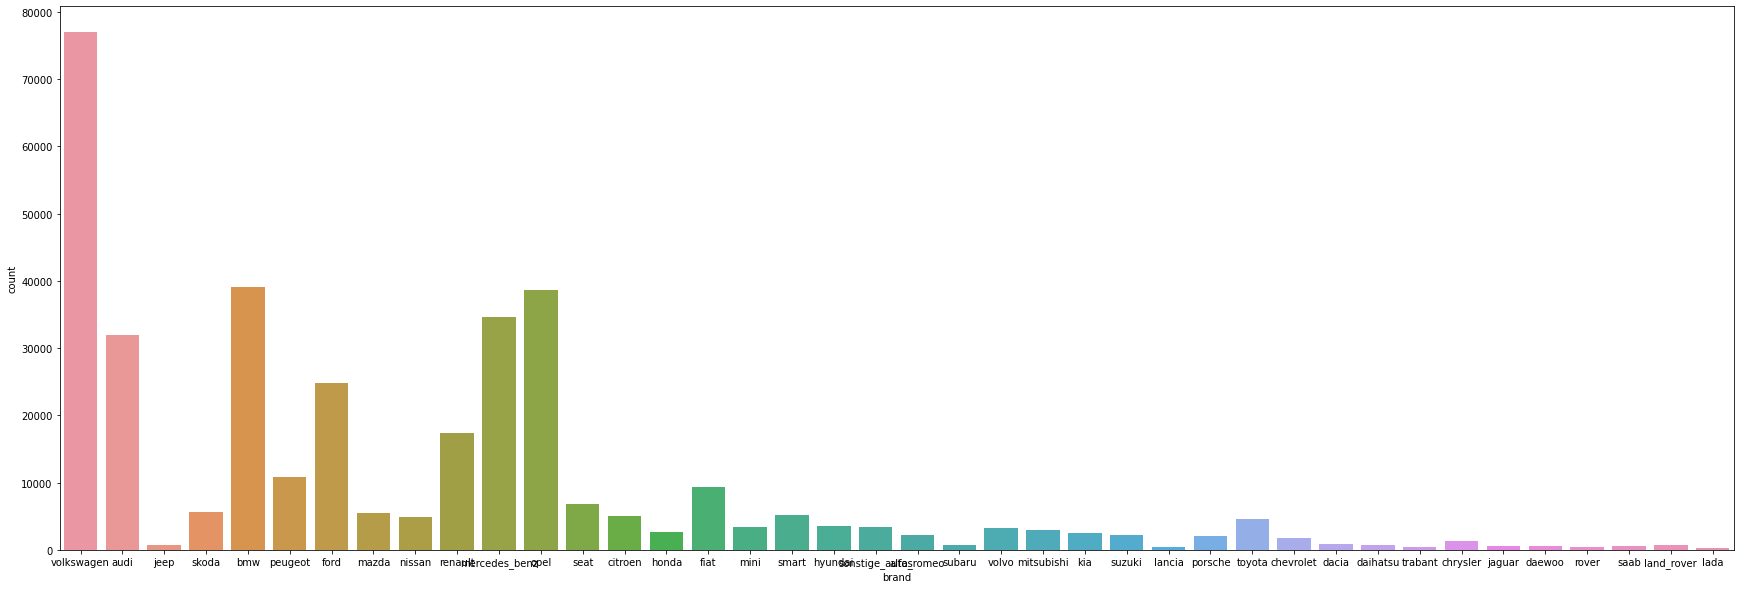

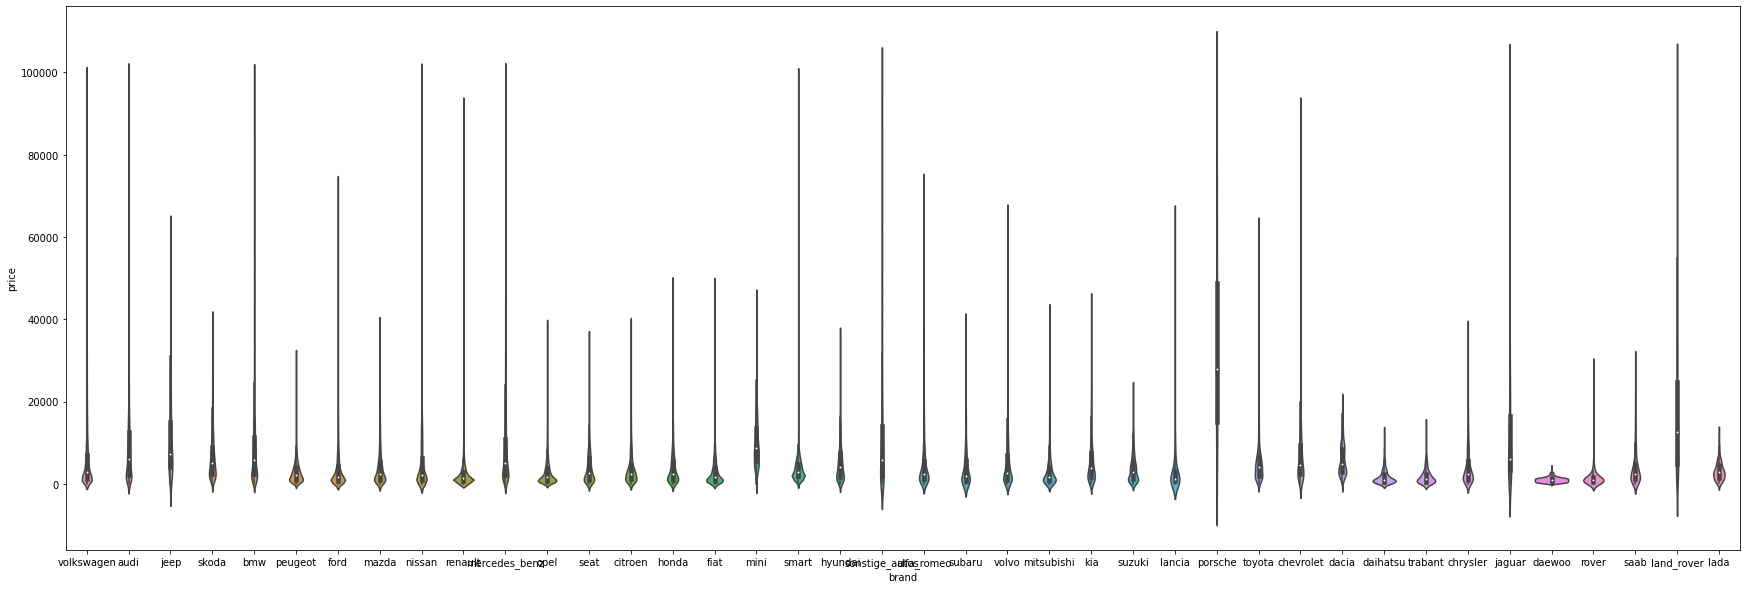

In [73]:
brand_graph = px.bar(x=brand_count.index, y=brand_count.values, labels={'x':'Brand', 'y':'Number of Cars'})
brand_graph.show()

brand_count.plot.bar()
plt.show()

plt.figure(figsize=(30,10))
sns.countplot(x='brand', data=data)
plt.show()

plt.figure(figsize=(30,10))
sns.violinplot(x = "brand", y = "price", data=data);
plt.show()

In [74]:
model_count = data['model'].value_counts()
print(model_count)

print("\nNumber of Unique Values:")
print(data["model"].nunique())

print("\nUnique Values:")
data.model.unique()

golf               29059
andere             25597
3er                19976
0                  18132
polo               12647
                   ...  
serie_2                8
rangerover             6
serie_3                3
serie_1                1
discovery_sport        1
Name: model, Length: 252, dtype: int64

Number of Unique Values:
252

Unique Values:


array(['golf', 0, 'grand', 'fabia', '3er', '2_reihe', 'c_max', '3_reihe',
       'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse', 'scirocco',
       '5er', 'meriva', 'arosa', 'andere', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'one', 'fortwo',
       '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta', 'fiesta',
       'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'corsa', 'a6', 'jazz', 'omega', 'slk', '7er', '80',
       '147', 'glk', '100', 'z_reihe', 'sportage', 'sorento', 'v40',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'a3', 'almera',
       'megane', 'lupo', 'r19', 'zafira', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'm_klasse', 'tiguan',
       'i_reihe', 'espace', 'sharan', '6_reihe', 'panda', 'up',
       'seicento', 'ceed', '5_reihe', 'yeti', 'octavia', 'mii',
       'rx_reih

In [75]:
fuelType_count = data['fuelType'].value_counts()
print(fuelType_count)

print("\nNumber of Unique Values:")
print(data["fuelType"].nunique())

print("\nUnique Values:")
data.fuelType.unique()

benzin     217926
diesel     106167
0           29773
lpg          5233
cng           559
hybrid        269
andere        172
elektro        96
Name: fuelType, dtype: int64

Number of Unique Values:
8

Unique Values:


array(['benzin', 'diesel', 0, 'lpg', 'andere', 'hybrid', 'cng', 'elektro'],
      dtype=object)

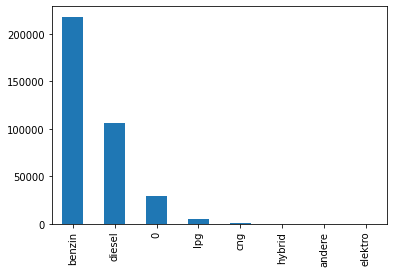

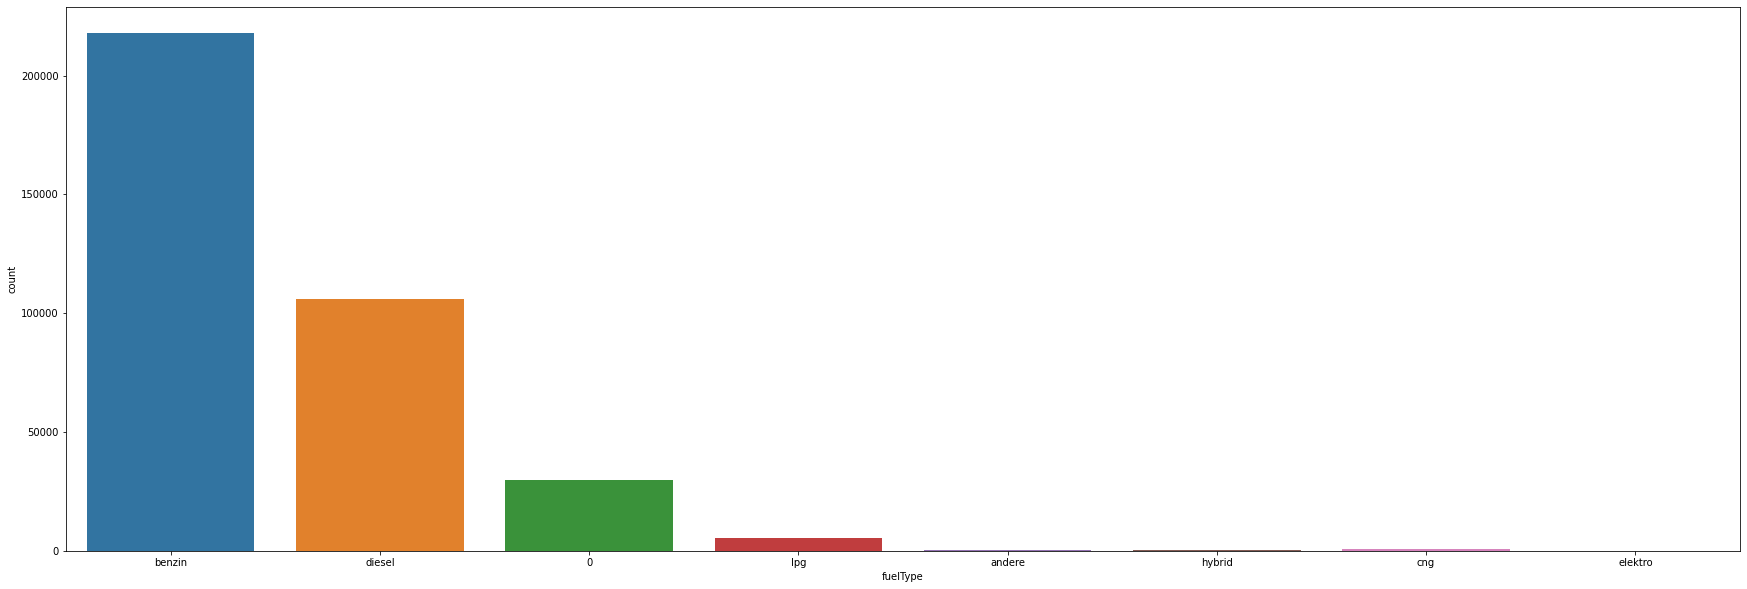

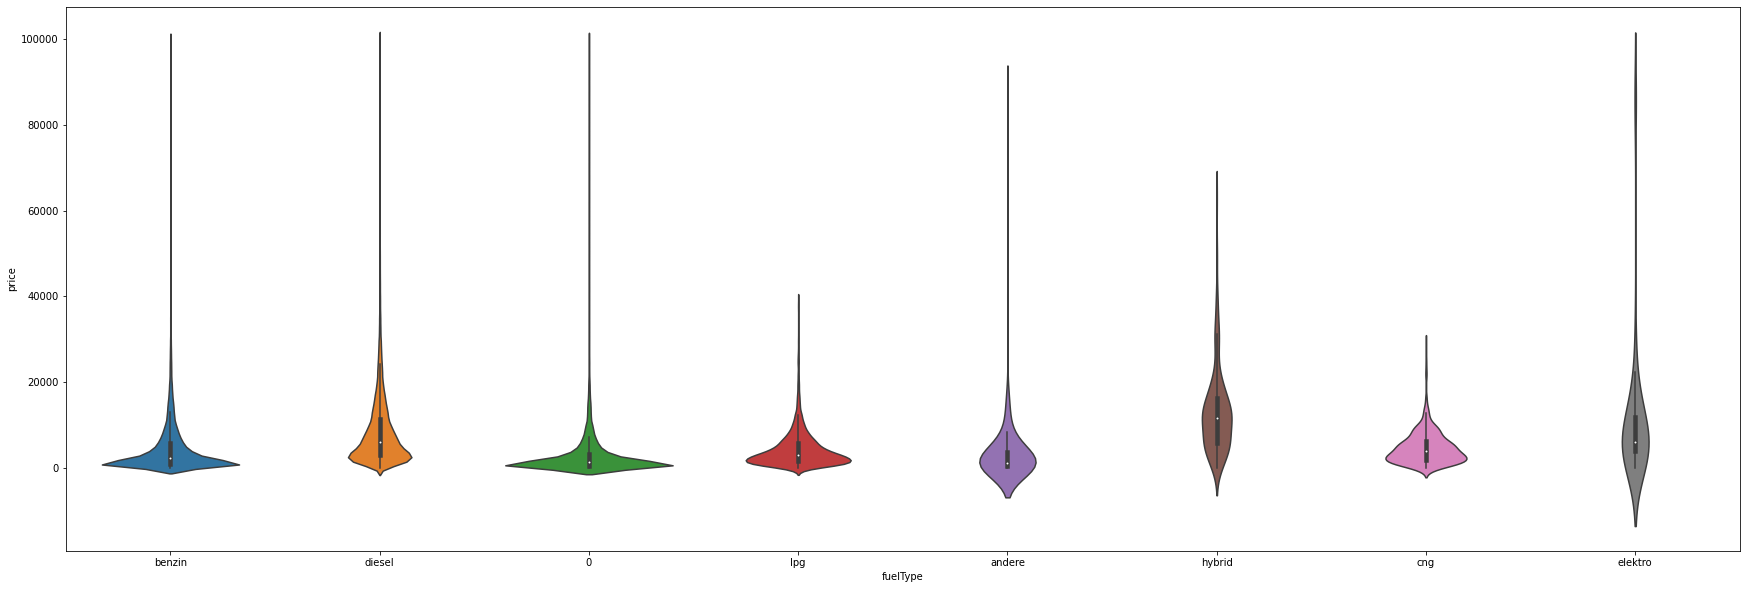

In [76]:
fuelType_graph = px.bar(x=fuelType_count.index, y=fuelType_count.values, labels={'x':'Fuel Type', 'y':'Number of Cars'})
fuelType_graph.show()

fuelType_count.plot.bar()
plt.show()

plt.figure(figsize=(30,10))
sns.countplot(x='fuelType', data=data)
plt.show()

plt.figure(figsize=(30,10))
sns.violinplot(x = "fuelType", y = "price", data=data);
plt.show()

In [77]:
yearOfRegistration_count = data['yearOfRegistration'].value_counts()
print(yearOfRegistration_count)

print("\nNumber of Unique Values:")
print(data["yearOfRegistration"].nunique())

print("\nUnique Values:")
data.yearOfRegistration.unique()

2000    23115
1999    22029
2005    21723
2006    20000
2001    19738
        ...  
1942        2
1940        2
1946        2
1911        1
1925        1
Name: yearOfRegistration, Length: 97, dtype: int64

Number of Unique Values:
97

Unique Values:


array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1968, 1982, 1976, 1983, 1959, 1973, 1969, 1971, 1987, 1986,
       1988, 1967, 1980, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978,
       1972, 1977, 1961, 1963, 1964, 1966, 1975, 1937, 1936, 1960, 1958,
       1956, 1933, 1941, 1962, 1929, 1951, 1957, 1940, 1949, 2019, 1953,
       1935, 1954, 1950, 1948, 1952, 1932, 1927, 1923, 1931, 1942, 1911,
       1930, 1944, 1943, 1947, 1934, 1938, 1928, 1939, 1946])

In [78]:
powerPS_count = data['powerPS'].value_counts()
print(powerPS_count)

print("\nNumber of Unique Values:")
print(data["powerPS"].nunique())

print("\nUnique Values:")
data.powerPS.unique()

0       36783
75      23323
60      15472
150     15020
140     13442
        ...  
1151        1
685         1
397         1
6011        1
564         1
Name: powerPS, Length: 769, dtype: int64

Number of Unique Values:
769

Unique Values:


array([    0,   190,   163,    75,    69,   102,   109,   125,   101,
         105,   140,   115,   131,    60,   136,   160,   231,    90,
          50,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   204,   155,    54,   185,
          87,   180,    86,    84,   303,   224,   235,   200,   178,
         265,    77,   110,   144,   120,   116,   184,   126,    88,
         194,   305,   197,   179,   250,    45,   313,    41,   165,
          98,   130,   114,   211,    56,   326,   201,   213,    58,
         107,    83,   174,   100,   220,    85,    73,   192,    68,
          66,   299,    74,    52,   510,   147,    65,   310,    71,
          97,   239,   295,   203,     5,   300,   103,   245,   258,
         292,   320,    63,    81,   148,   354,    44,   145,   280,
         260,   457,   104,   409,   188,   333,   186,   117,   141,
          59,   132,

In [79]:
gearbox_count = data['gearbox'].value_counts()
print(gearbox_count)

print("\nNumber of Unique Values:")
print(data["gearbox"].nunique())

print("\nUnique Values:")
data.gearbox.unique()

0    267106
1     75545
2     17544
Name: gearbox, dtype: int64

Number of Unique Values:
3

Unique Values:


array([0, 1, 2])

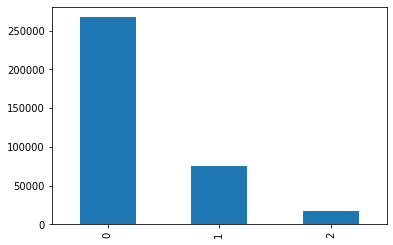

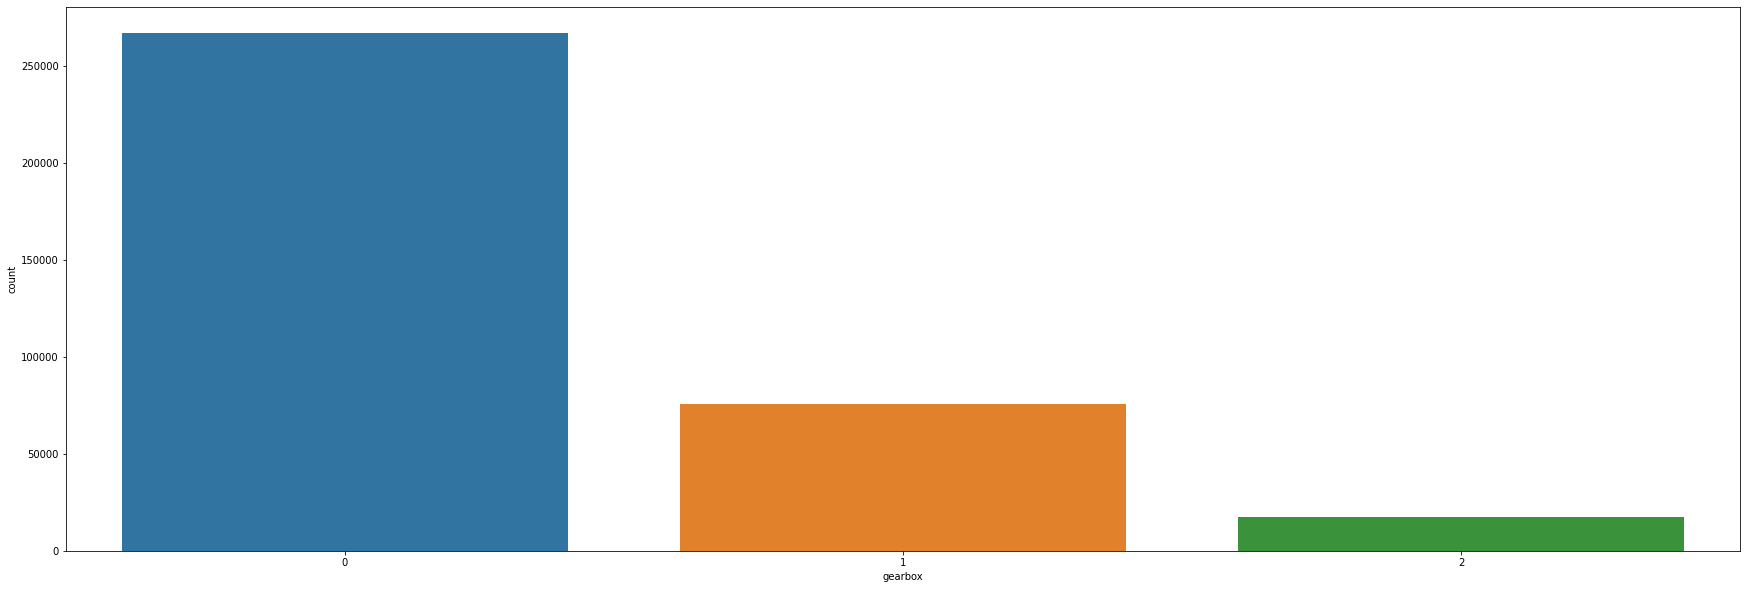

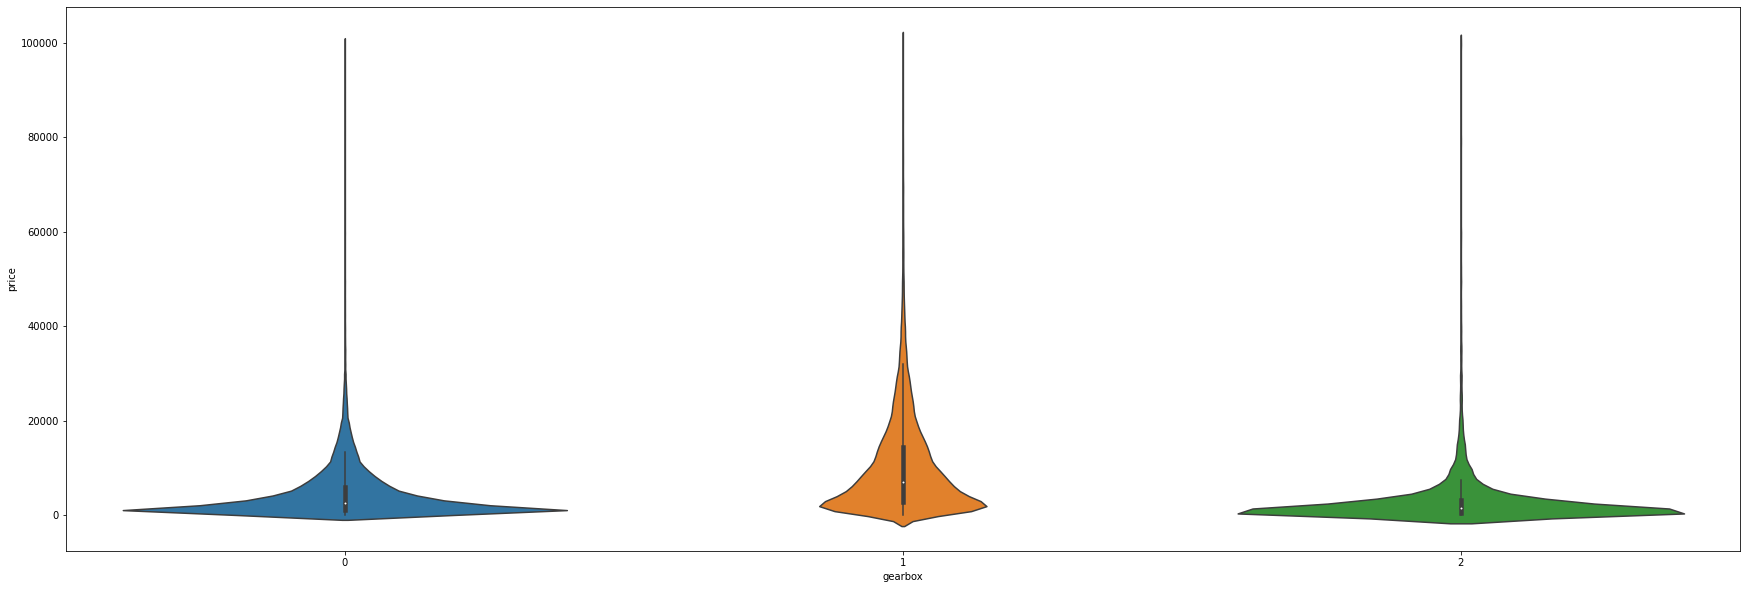

In [80]:
gearbox_graph = px.bar(x=gearbox_count.index, y=gearbox_count.values, labels={'x':'Gear Box', 'y':'Number of Cars'})
gearbox_graph.show()

gearbox_count.plot.bar()
plt.show()

plt.figure(figsize=(30,10))
sns.countplot(x='gearbox', data=data)
plt.show()

plt.figure(figsize=(30,10))
sns.violinplot(x = "gearbox", y = "price", data=data);
plt.show()

In [81]:
abtest_count = data['abtest'].value_counts()
print(abtest_count)

print("\nNumber of Unique Values:")
print(data["abtest"].nunique())

print("\nUnique Values:")
data.abtest.unique()

test       186577
control    173618
Name: abtest, dtype: int64

Number of Unique Values:
2

Unique Values:


array(['test', 'control'], dtype=object)

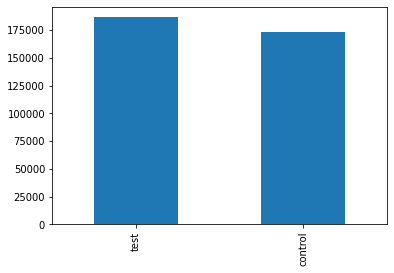

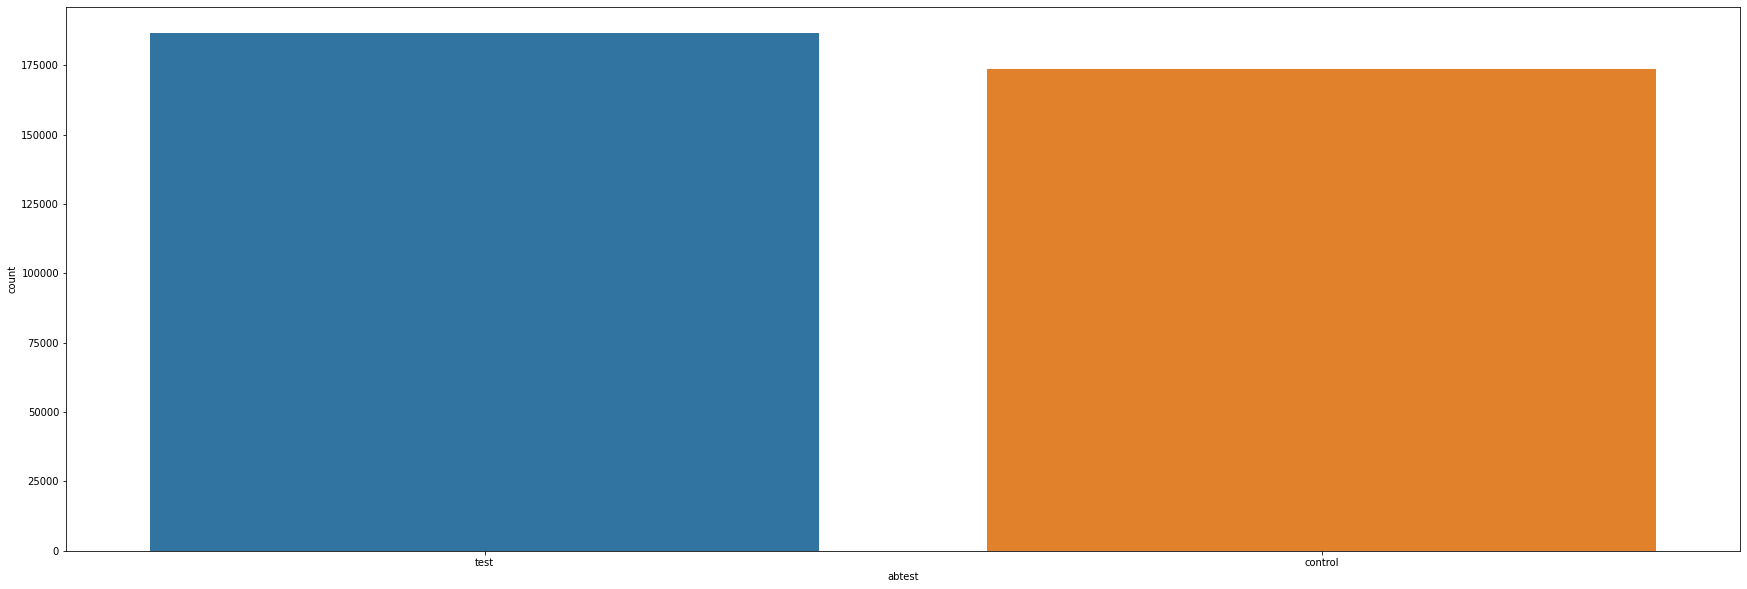

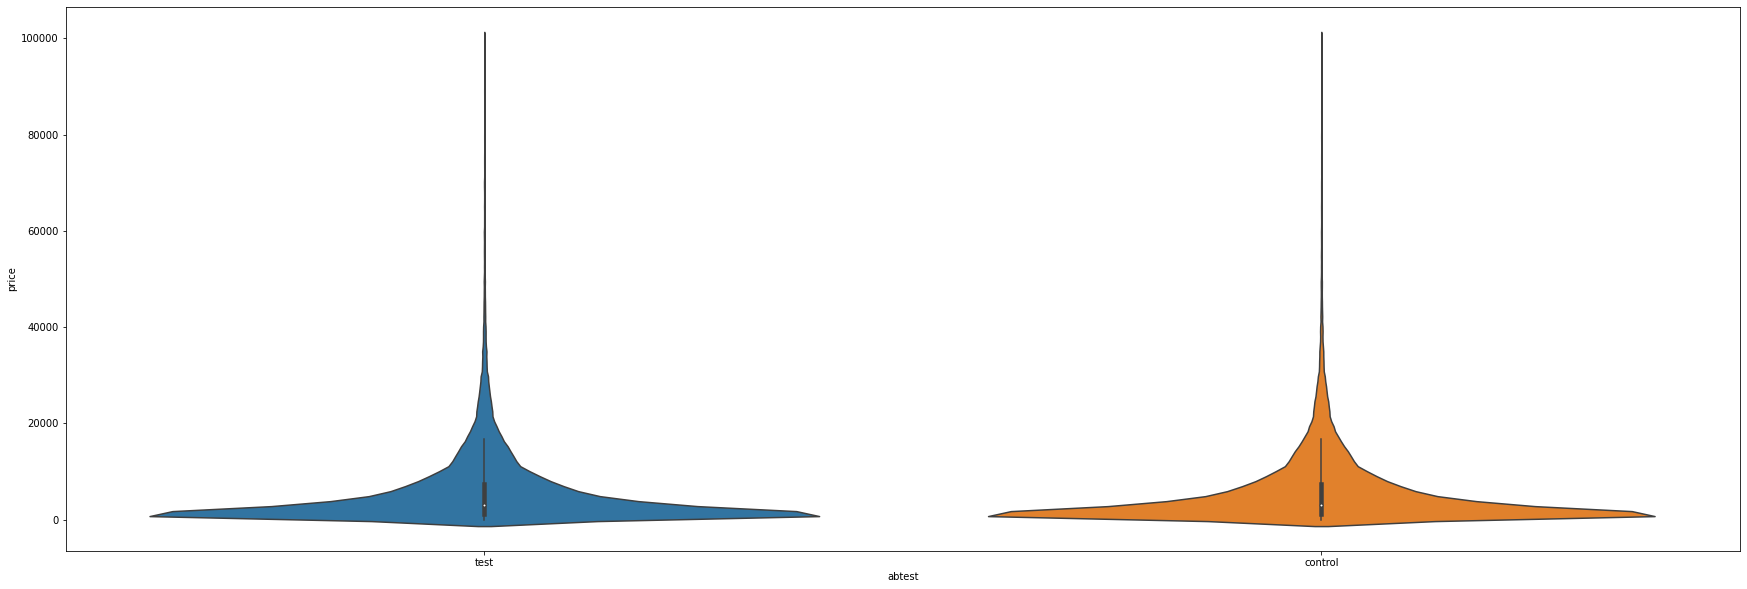

In [82]:
abtest_graph = px.bar(x=abtest_count.index, y=abtest_count.values, labels={'x':'Abtest', 'y':'Number of Cars'})
abtest_graph.show()

abtest_count.plot.bar()
plt.show()

plt.figure(figsize=(30,10))
sns.countplot(x='abtest', data=data)
plt.show()

plt.figure(figsize=(30,10))
sns.violinplot(x = "abtest", y = "price", data=data);
plt.show()

In [83]:
data_volkswagen = data.loc[data.brand == 'volkswagen']

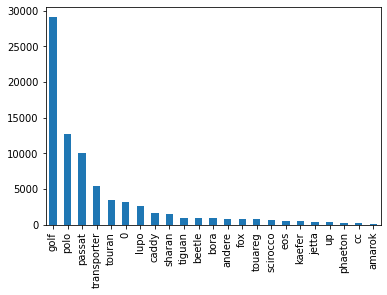

In [84]:
# options 1
volkswagen_counts = data_volkswagen['model'].value_counts().plot(kind='bar')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



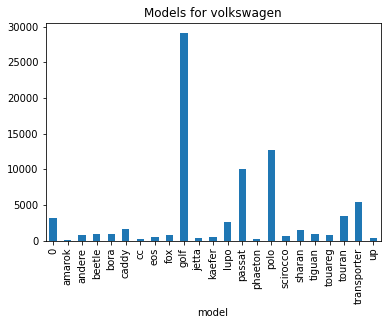

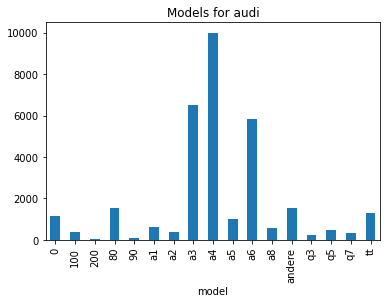

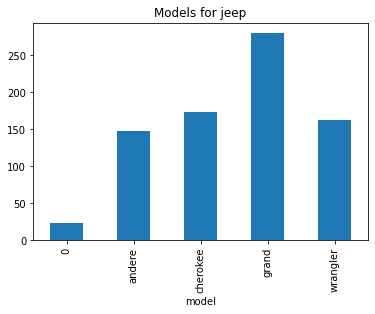

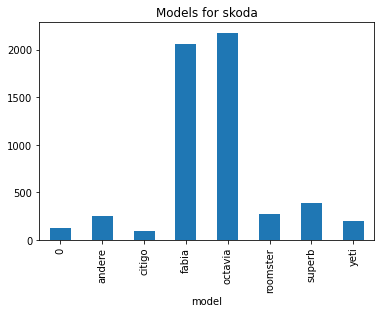

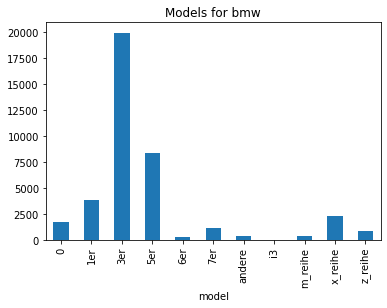

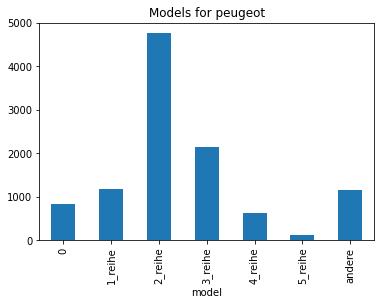

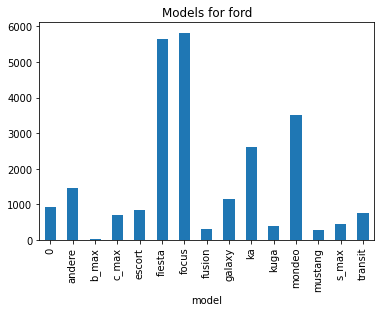

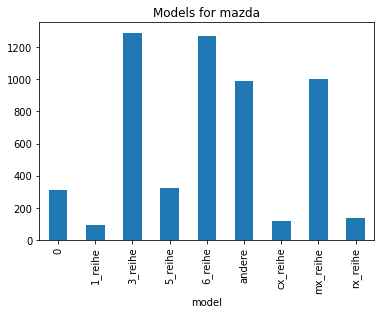

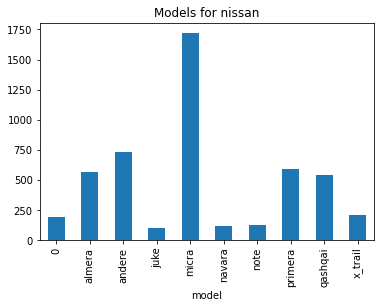

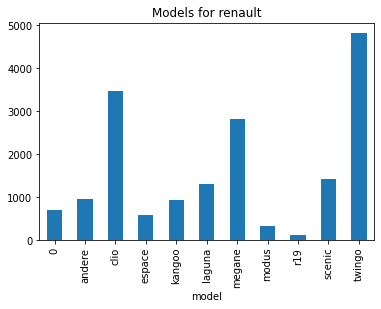

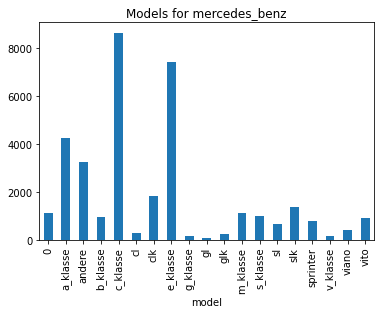

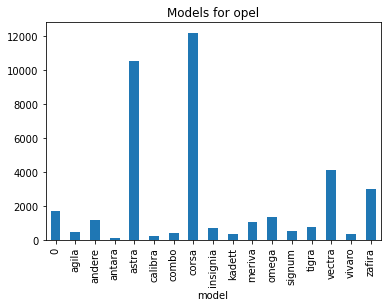

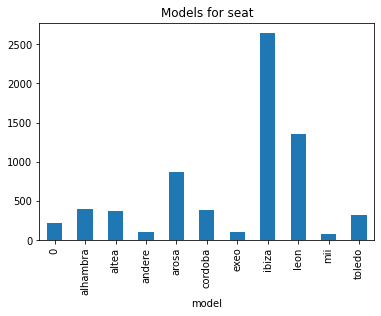

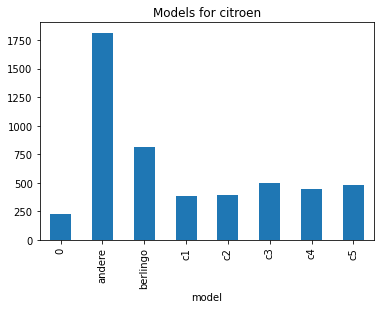

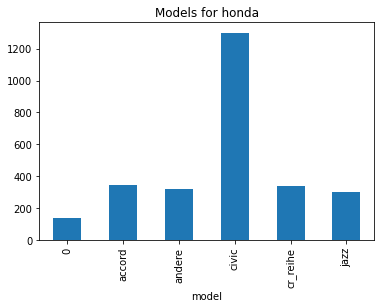

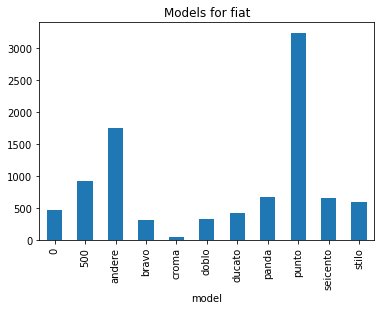

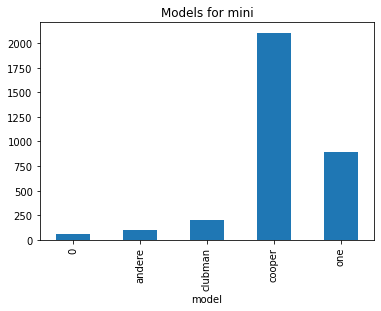

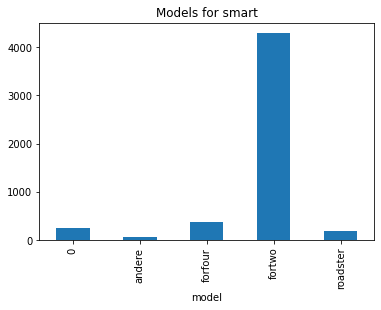

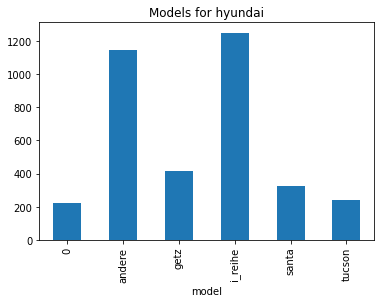

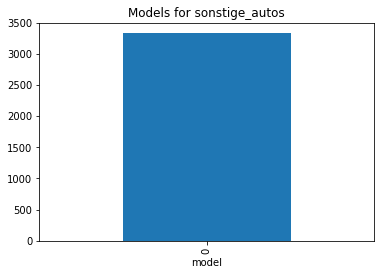

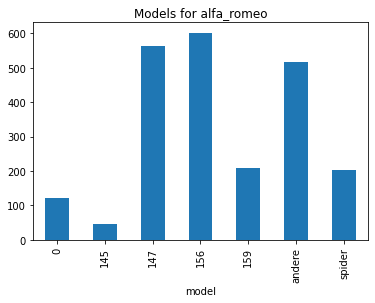

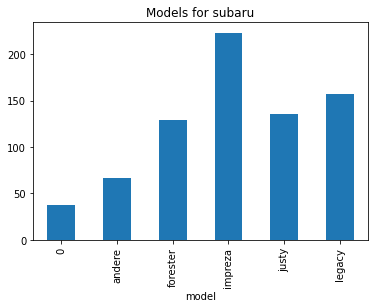

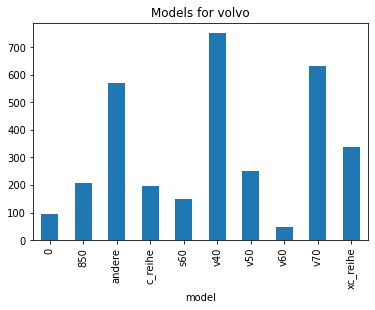

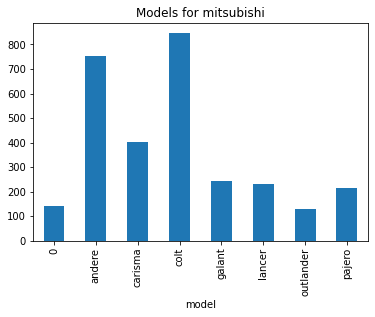

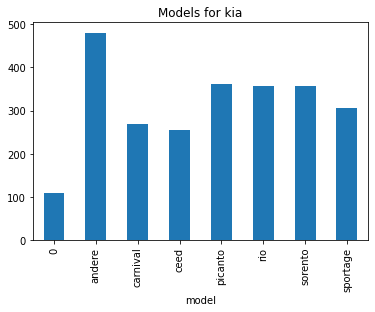

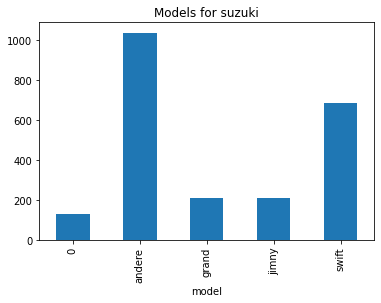

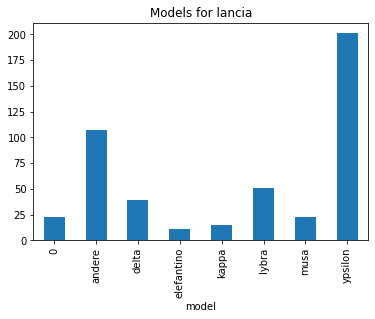

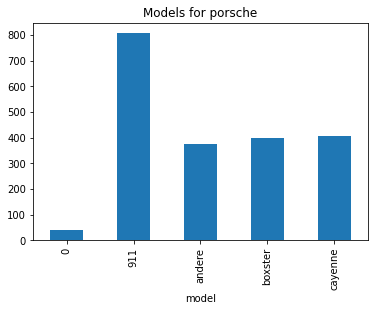

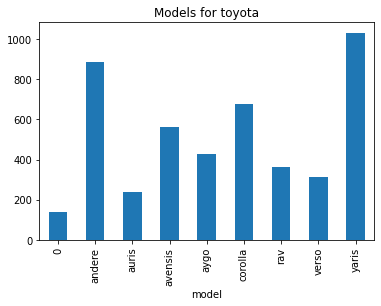

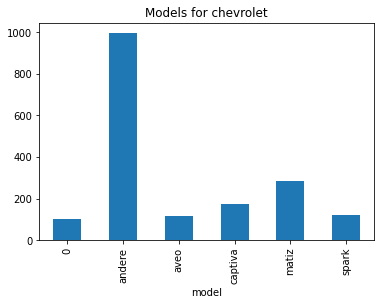

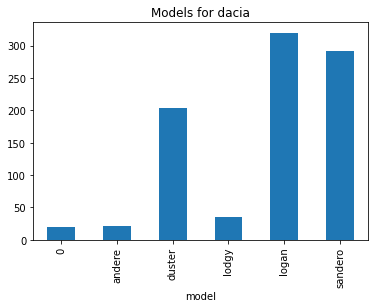

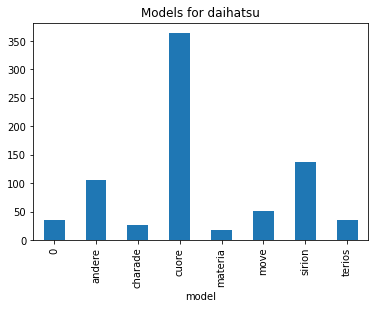

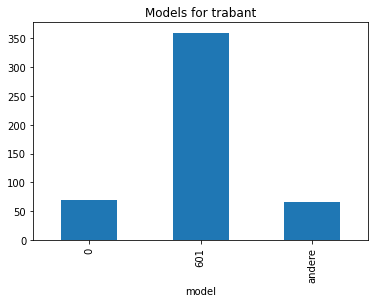

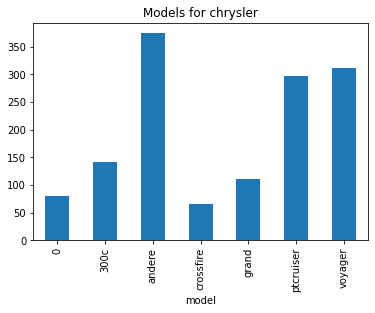

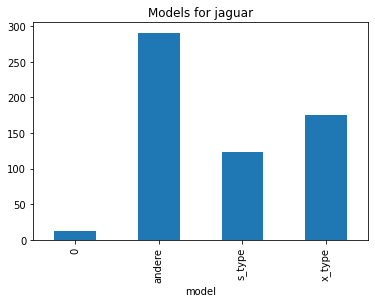

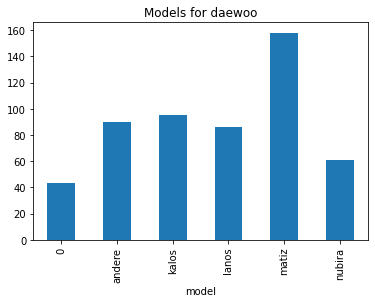

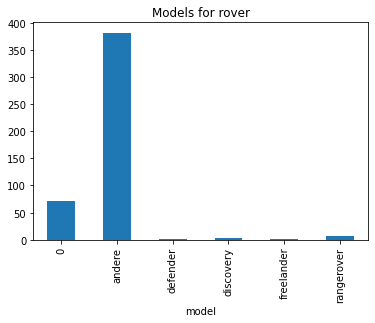

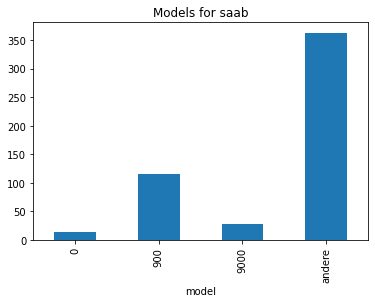

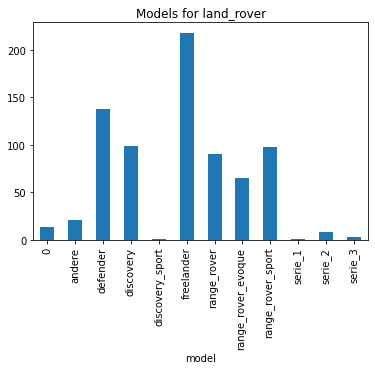

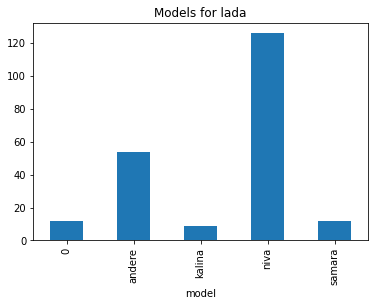

In [85]:
# options 2
for brand in data['brand'].unique():
    data_brand = data.loc[data.brand == brand]
    model_counts = data_brand.groupby('model').size()
    plt.figure()
    model_counts.plot(kind='bar')
    plt.title(f'Models for {brand}')

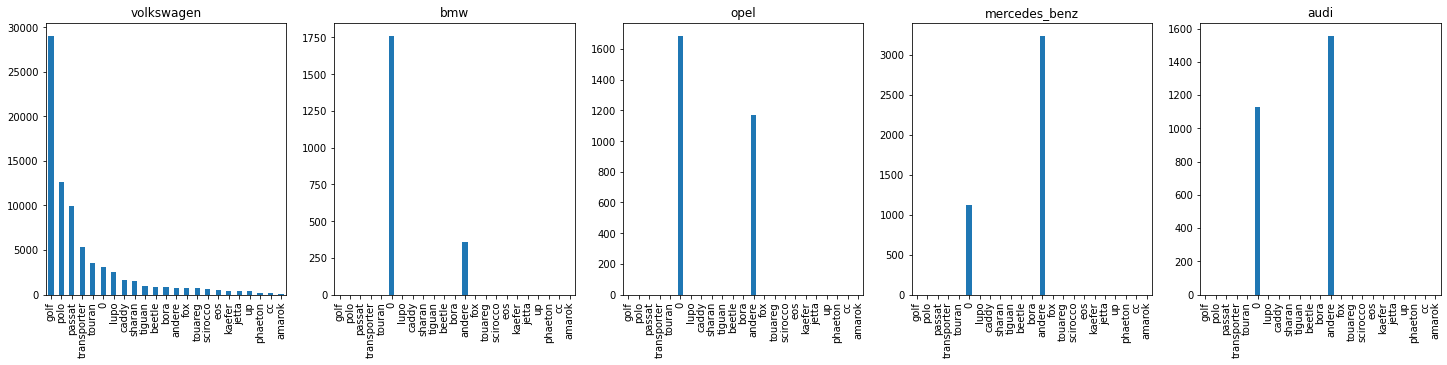

In [86]:
top_brands = data['brand'].value_counts().nlargest(5)

data_models = pd.DataFrame()
for brand in top_brands.index:
    data_models[brand] = data[data['brand'] == brand]['model'].value_counts()
    
fig, ax = plt.subplots(1, 5, figsize=(25, 5))

for i, brand in enumerate(top_brands.index):
    data_models[brand].plot.bar(ax=ax[i])
    ax[i].set_title(brand)

# Show the plot
plt.show()

In [87]:
#  Her marka için en yüksek sayıya sahip modeli bulma
top_models = {}
for brand in top_brands.index:
    top_model = data_models[brand].idxmax()
    top_models[brand] = top_model
print(top_models)

{'volkswagen': 'golf', 'bmw': 0, 'opel': 0, 'mercedes_benz': 'andere', 'audi': 'andere'}


In [88]:
print("Automatik Models:")
automatik_data = data[data['gearbox'] == 'automatik']
model_counts = automatik_data['model'].value_counts()
print(model_counts)
print("\n\nManuell Models:")
manuell_data = data[data['gearbox'] == 'manuell']
model_counts = manuell_data['model'].value_counts()
print(model_counts)

Automatik Models:
Series([], Name: model, dtype: int64)


Manuell Models:
Series([], Name: model, dtype: int64)


In [89]:
print("Benzin Models:")
benzin_data = data[data['fuelType'] == 'benzin']
model_counts = benzin_data['model'].value_counts()
print(model_counts)
print("\n\nDiesel Models:")
diesel_data = data[data['fuelType'] == 'diesel']
model_counts = diesel_data['model'].value_counts()
print(model_counts)
print("\n\nLpg Models:")
lpg_data = data[data['fuelType'] == 'lpg']
model_counts = lpg_data['model'].value_counts()
print(model_counts)
print("\n\nCng Models:")
cng_data = data[data['fuelType'] == 'cng']
model_counts = cng_data['model'].value_counts()
print(model_counts)

Benzin Models:
golf                  19378
andere                16677
3er                   13138
corsa                 10269
polo                  10146
                      ...  
serie_3                   2
defender                  2
rangerover                1
range_rover_evoque        1
navara                    1
Name: model, Length: 249, dtype: int64


Diesel Models:
golf        7285
andere      6288
passat      5650
3er         5291
a4          4996
            ... 
jazz           1
rx_reihe       1
calibra        1
seicento       1
up             1
Name: model, Length: 226, dtype: int64


Lpg Models:
andere      649
0           353
3er         327
5er         232
e_klasse    217
           ... 
up            1
s_max         1
nubira        1
cuore         1
fortwo        1
Name: model, Length: 192, dtype: int64


Cng Models:
zafira         111
caddy           76
touran          50
combo           41
andere          35
golf            23
0               20
panda           17


In [90]:
print("Limousine Models:")
limousine_data = data[data['vehicleType'] == 'limousine']
model_counts = limousine_data['model'].value_counts()
print(model_counts)
print("\n\nKleinwagen Models:")
kleinwagen_data = data[data['vehicleType'] == 'kleinwagen']
model_counts = kleinwagen_data['model'].value_counts()
print(model_counts)
print("\n\nKombi Models:")
kombi_data = data[data['vehicleType'] == 'kombi']
model_counts = kombi_data['model'].value_counts()
print(model_counts)
print("\n\nBus Models:")
bus_data = data[data['vehicleType'] == 'bus']
model_counts = bus_data['model'].value_counts()
print(model_counts)
print("\n\nCabrio Models:")
cabrio_data = data[data['vehicleType'] == 'cabrio']
model_counts = cabrio_data['model'].value_counts()
print(model_counts)
print("\n\nCoupe Models:")
coupe_data = data[data['vehicleType'] == 'coupe']
model_counts = coupe_data['model'].value_counts()
print(model_counts)
print("\n\nSuv Models:")
suv_data = data[data['vehicleType'] == 'suv']
model_counts = suv_data['model'].value_counts()
print(model_counts)
print("\n\nAndere Models:")
andere_data = data[data['vehicleType'] == 'andere']
model_counts = andere_data['model'].value_counts()
print(model_counts)

Limousine Models:
golf        15057
3er          8123
andere       5563
5er          4802
c_klasse     4269
            ...  
s_max           1
cayenne         1
v50             1
materia         1
sorento         1
Name: model, Length: 208, dtype: int64


Kleinwagen Models:
corsa       10267
polo        10054
fiesta       4683
twingo       4071
golf         3741
            ...  
s_klasse        1
m_reihe         1
verso           1
calibra         1
a6              1
Name: model, Length: 163, dtype: int64


Kombi Models:
passat       7082
a4           5454
3er          4700
a6           3608
astra        3231
             ... 
micra           1
lupo            1
musa            1
outlander       1
kappa           1
Name: model, Length: 175, dtype: int64


Bus Models:
transporter    4640
andere         4263
touran         2704
zafira         2378
sharan         1196
               ... 
sl                1
punto             1
materia           1
tucson            1
4_reihe           1


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



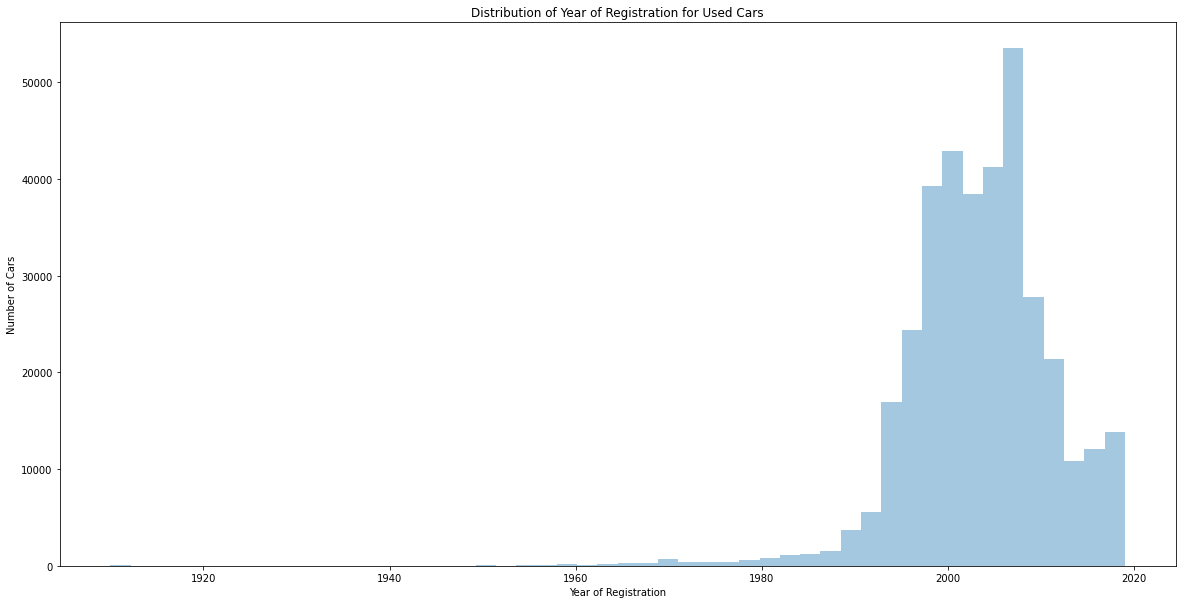

In [91]:
plt.figure(figsize=(20,10))
sns.distplot(data['yearOfRegistration'], kde=False)
plt.xlabel('Year of Registration')
plt.ylabel('Number of Cars')
plt.title('Distribution of Year of Registration for Used Cars')
plt.show()

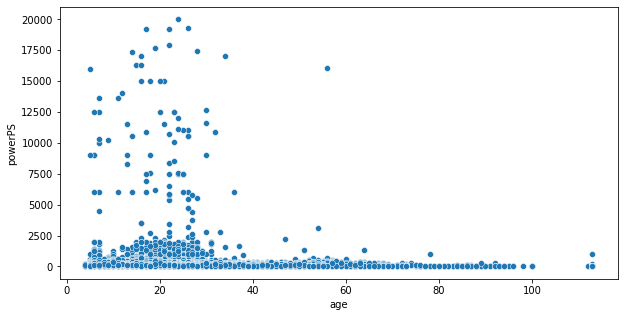

In [92]:
current_year = 2023
data['age'] = current_year - data['yearOfRegistration']
plt.figure(figsize=(10, 5))
sns.scatterplot(x='age', y='powerPS', data=data)
plt.show()

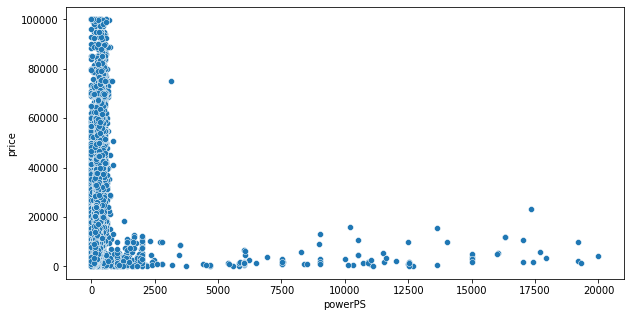

In [93]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='powerPS', y='price', data=data)
plt.show()

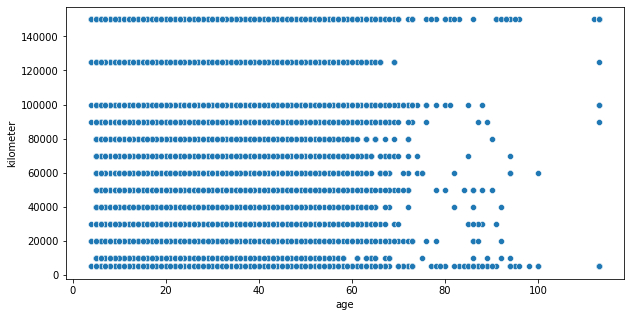

In [94]:
current_year = 2023
data['age'] = current_year - data['yearOfRegistration']
plt.figure(figsize=(10, 5))
sns.scatterplot(x='age', y='kilometer', data=data)
plt.show()

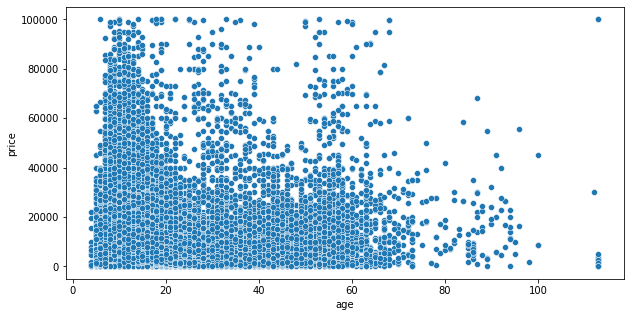

In [95]:
current_year = 2023
data['age'] = current_year - data['yearOfRegistration']
plt.figure(figsize=(10, 5))
sns.scatterplot(x='age', y='price', data=data)
plt.show()

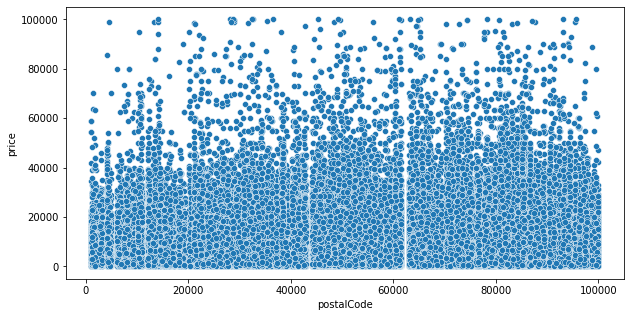

In [96]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='postalCode', y='price', data=data)
plt.show()

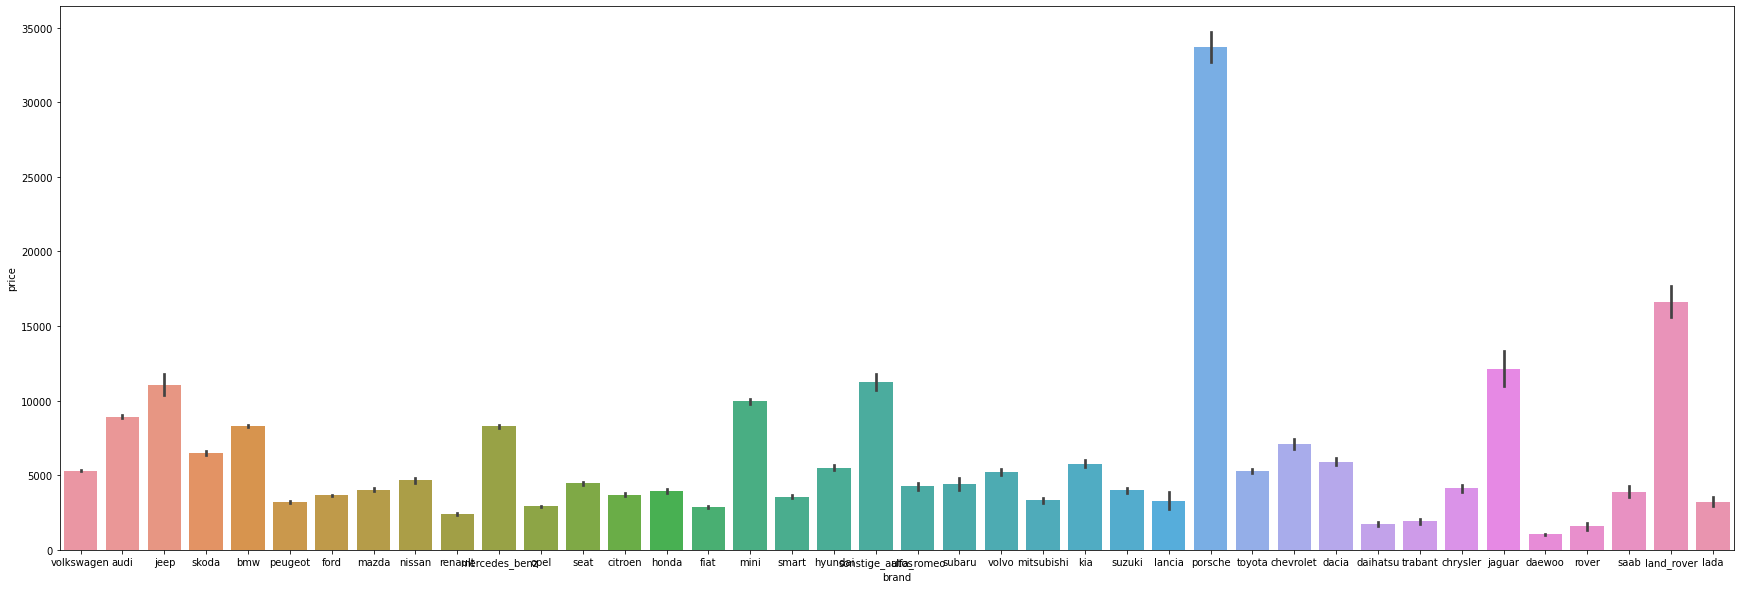

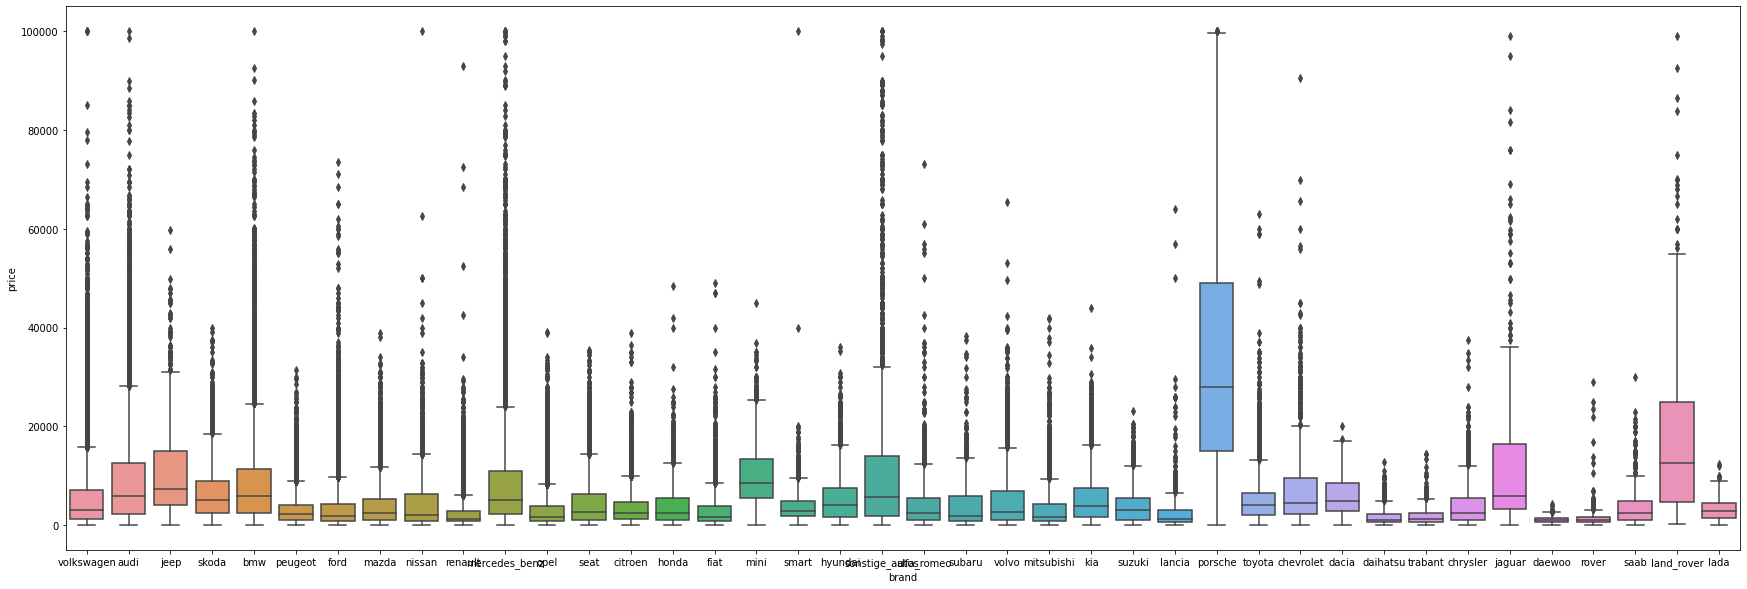

In [97]:
plt.figure(figsize=(30, 10))
sns.barplot(x='brand', y='price', data=data)
plt.show()

plt.figure(figsize=(30, 10))
sns.boxplot(x='brand', y='price', data=data)
plt.show()

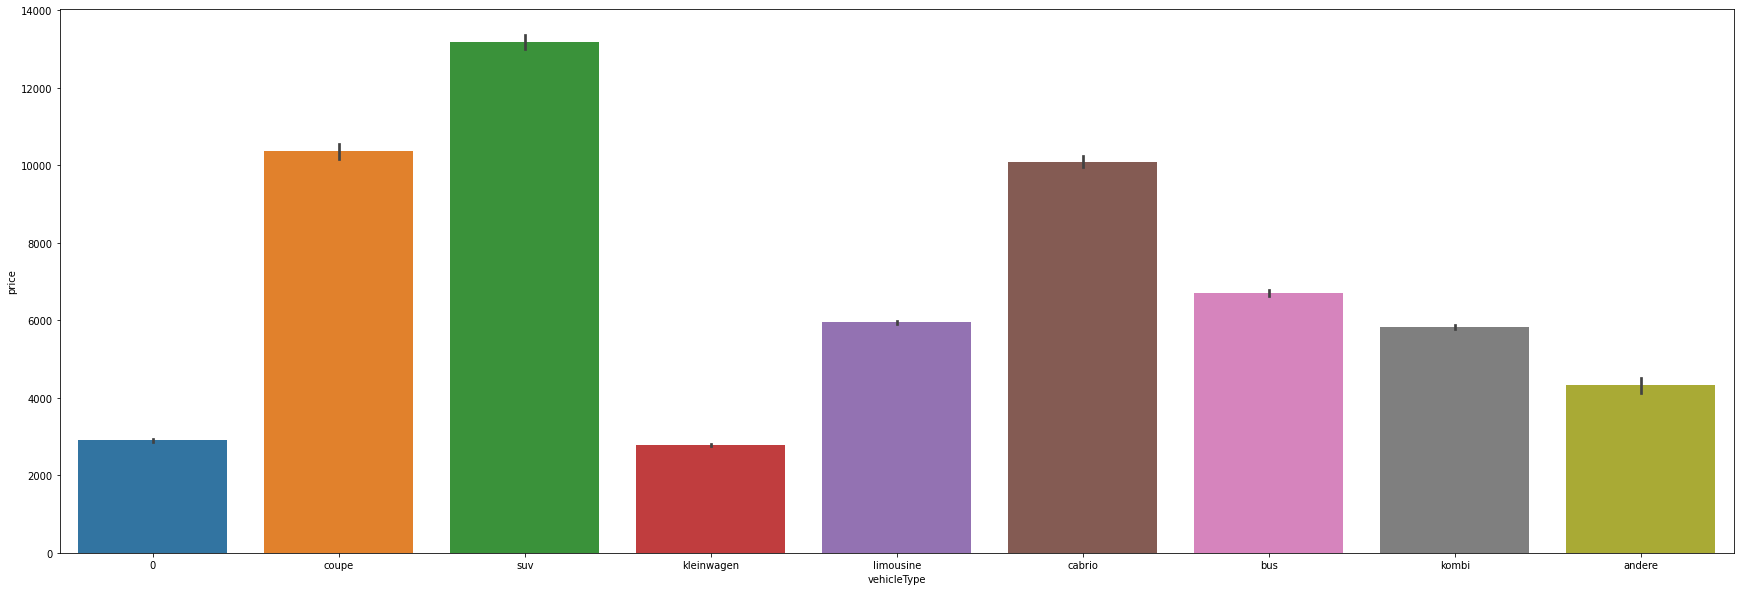

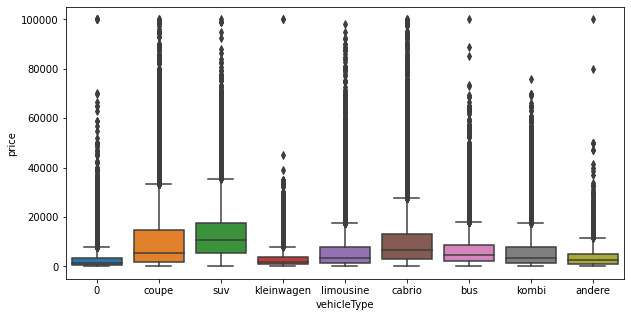

In [98]:
plt.figure(figsize=(30, 10))
sns.barplot(x='vehicleType', y='price', data=data)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='vehicleType', y='price', data=data)
plt.show()

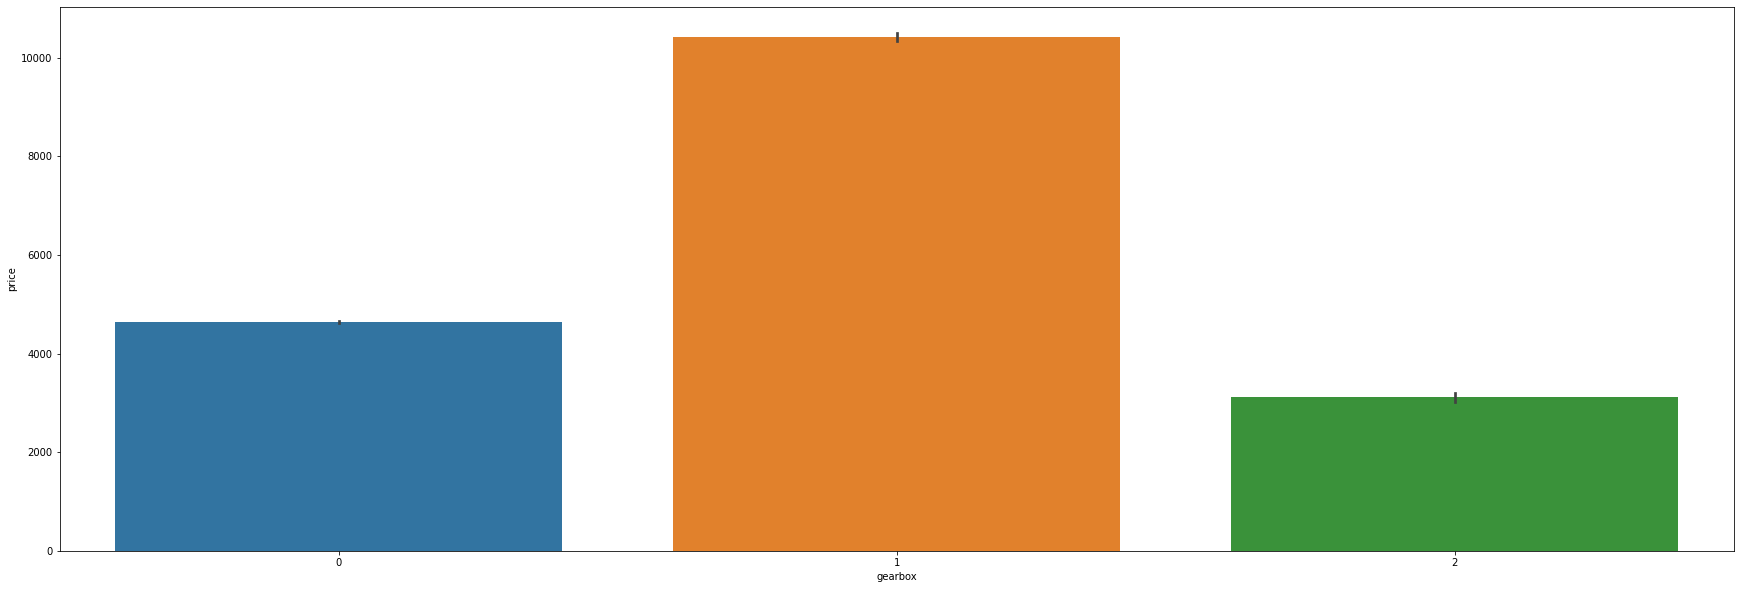

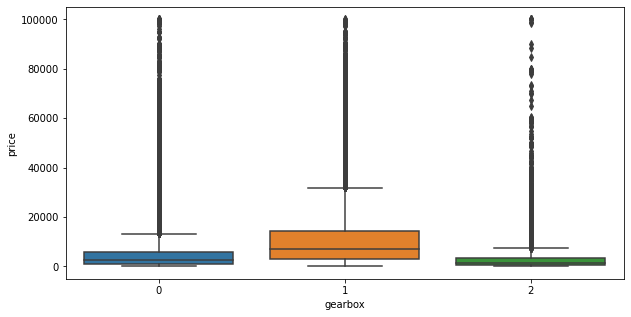

In [99]:
plt.figure(figsize=(30, 10))
sns.barplot(x='gearbox', y='price', data=data)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='gearbox', y='price', data=data)
plt.show()

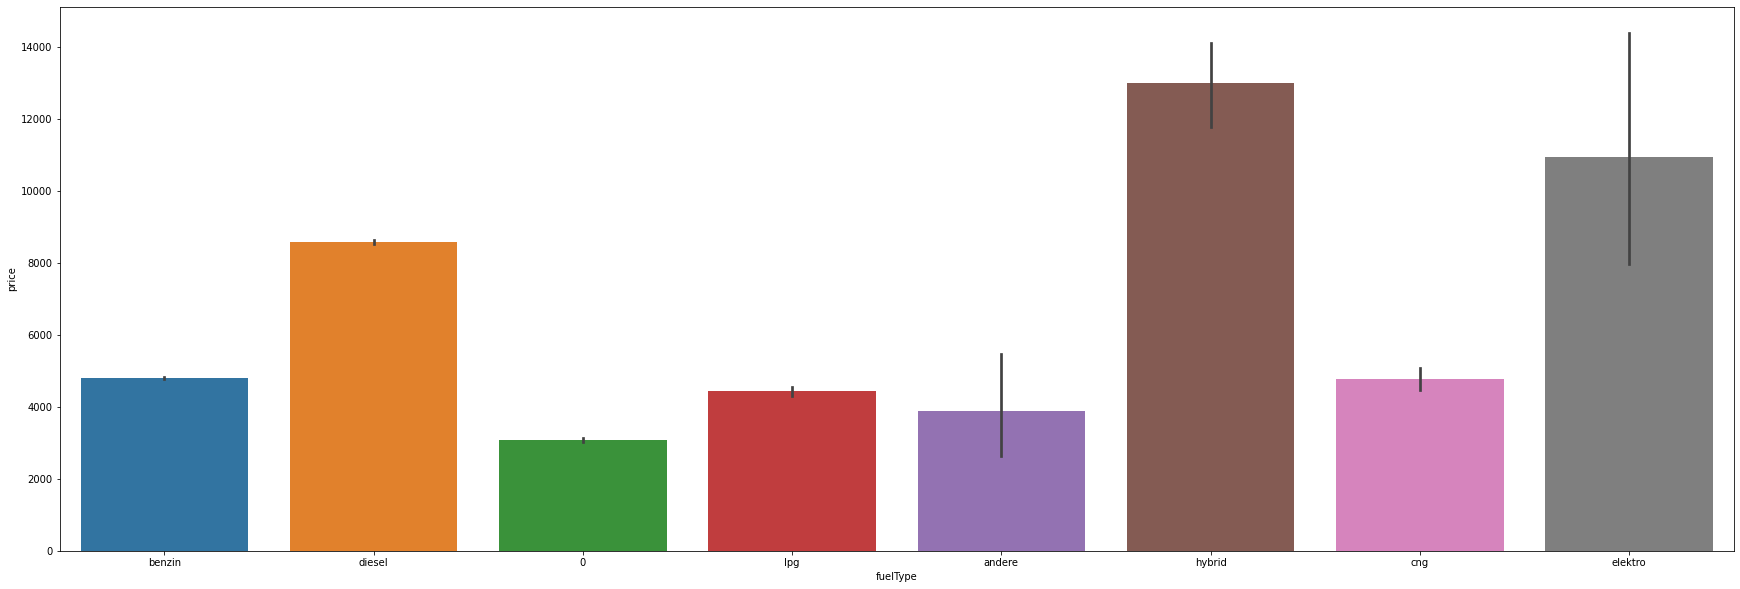

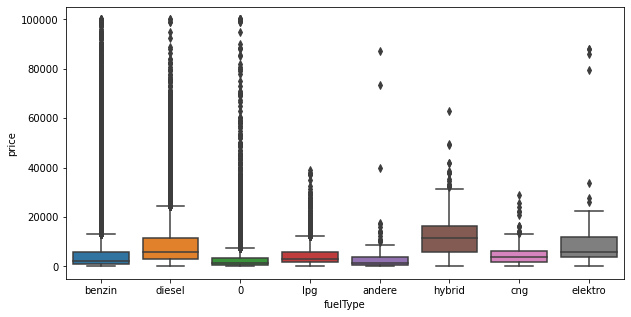

In [100]:
plt.figure(figsize=(30, 10))
sns.barplot(x='fuelType', y='price', data=data)
plt.show()

plt.figure(figsize=(10, 5))
sns.boxplot(x='fuelType', y='price', data=data)
plt.show()

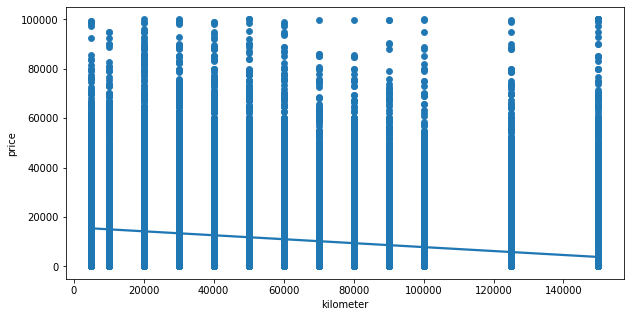

In [101]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='kilometer', y='price', data=data)
sns.regplot(x='kilometer', y='price', data=data)
plt.show()

In [102]:
data = data.sort_values(by='powerPS', ascending=False)
top_10_cars = data.head(10)
print(top_10_cars[['name','powerPS']])

                                                     name  powerPS
223167                     Mercedes_CLK_430___8_Zylinder_    20000
304116                                  Verkaufe_BMW_528i    19312
116018            BMW_120D_Diesel_M_packet_Vollauslastung    19211
134655                                   BMW_E39_5er_525i    19208
65032                                          Opel_Omega    17932
199773                           Verkaufe_meinen_bmw_525d    17700
153168               Audi_80_Avant_2.8_V6_RS2_Optik_/_LPG    17410
53792                        BMW_E70_X5_3.0D_Panoramadach    17322
190415  BMW_E30_touring_325i_Projektaufgabe_325e_viele...    17019
178321              Audi_a3_2_0_tdi_s_line_plus_125kW_dsg    17011


In [103]:
data = data.sort_values(by='kilometer', ascending=False)
top_10_cars = data.head(10)
print(top_10_cars[['name','kilometer']])

                                                     name  kilometer
223167                     Mercedes_CLK_430___8_Zylinder_     150000
242609                              Opel_astra_h_1_7_cdti     150000
242611                               Opel_Astra_1.9_101cv     150000
170415                             Renault_Trafic_1.9_dCi     150000
134531                                         Golf_4_TDI     150000
91044   VW_Golf_4_3_Cabrio_1_6_TÜV_u_Dach_Neu_der_Somm...     150000
152131                      Volkswagen_Passat_Variant_1.6     150000
281995                              Ford_Fiesta_1.6_Sport     150000
232091  Volkswagen_Lupo_1.4_16V_TÜV_12/2017_Zahnriemen...     150000
26876                                         Audi_A3_1.6     150000


In [104]:
data = data.sort_values(by='price', ascending=False)
top_10_cars = data.head(10)
print(top_10_cars[['name','price']])

                                                     name  price
167316  SUCHE_VW_Corrado_Golf2_G60_16V_VR6_Zustand_ega...  99999
210921                                         Abarth_500  99999
305128  Suche_Porsche_997_Unfall__Motorschaden__Getrie...  99999
137492                    Nissan_X_Trail_2.2_Di_4x4_Sport  99999
211937                     Vw_golf_4_2.8_4_Motion__tausch  99999
332300                       Kaufe_LKW_bis_3_5_t_u._Autos  99999
358936           ANKAUF_BARGELD_AUTOS_PKW_LKW_ganz/defekt  99999
15880                               BMW_320d_Motorschaden  99999
17685                          Suche_VW_mit_Diesel__54_PS  99999
143394  Porsche_991__Cabrio_Blau_Garantie_Winter_/_Som...  99999


In [105]:
data.seller.unique()

array(['privat', 'gewerblich'], dtype=object)

In [106]:
# Fiyat sütununu sayısal bir türe dönüştürme
seller_data = data[data['seller'].isin(['privat', 'gewerblich'])]
seller_data['price'] = pd.to_numeric(seller_data['price'])

# Her satıcı türü için ortalama fiyatı hesaplama
mean_prices = seller_data.groupby('seller')['price'].mean()
print(mean_prices)

seller
gewerblich    2700.000000
privat        5774.452098
Name: price, dtype: float64
